This is a working file for the Deep Learning Assignment. In this notebook, model tuning is performed to find an optimal modification to the baseline model provided in the instructions.

Please refer to the main notebook file of the project: Assignment_DL_Jakob_Tjurlik.ipynb

## Pre-loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import ipython_config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers, models, utils

utils.set_random_seed(42)

file_dir = ipython_config.FILE_DIR
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
classes, class_indices = np.unique(labels, return_index=True)
n_classes=len(classes)

Mounted at /content/drive


In [ ]:
# The 3-way data splits were saved as a pkl file in the main notebook and were
# uploaded directly to this notebook

with open(file_dir + 'datasets.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

## Functions

In [ ]:
# Loss and accuracy plots over epochs

def plot_history(history, model_name):
    # Define relevant metrics
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(tr_acc) + 1)

    # Define plot style
    plt.figure(figsize= (22, 8))
    plt.style.use('ggplot')

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    epochs = range(1, len(tr_acc) + 1)  # Adjust epochs to start from 1
    plt.plot(epochs, tr_acc, label='Training Accuracy', lw=4, c='firebrick')
    plt.plot(epochs, val_acc, label='Validation Accuracy', lw=4, c='darkgreen')
    best_epoch_acc = np.argmax(val_acc)+1
    plt.scatter(best_epoch_acc, max(val_acc), c='mediumblue',
                s=100, label=f'Best epoch = {best_epoch_acc}')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.title(f'{model_name} Training and Validation Accuracy', fontsize=18, fontweight='bold')
    plt.legend(fontsize=15)
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, label='Training Loss', lw=4, c='firebrick')
    plt.plot(epochs, val_loss, label='Validation Loss', lw=4, c='darkgreen')
    best_epoch_loss = np.argmin(val_loss)+1
    plt.scatter(best_epoch_loss, min(val_loss), c='mediumblue',
                s=100, label=f'Best epoch = {best_epoch_loss}')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title(f'{model_name} Training and Validation Loss', fontsize=18, fontweight='bold')
    plt.legend(fontsize=15)
    plt.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.125)
    plt.show()

In [ ]:
# Display classification report and confusion matrix

def plot_cm(model, X, y, dataset_name, classes=classes):
    from sklearn.metrics import confusion_matrix, classification_report
    n_classes = len(classes)

    # Predict classes
    y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

    # Convert one-hot encoded y to class labels
    y_true = np.argmax(y, axis=1)

    # Print classification report
    print(f'Classification report of the {dataset_name} set:')
    print(classification_report(y_true, y_pred, target_names=classes))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                cmap=sns.cubehelix_palette(as_cmap=True),
                xticklabels=np.arange(n_classes), yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {dataset_name} set')
    plt.show()
    print()

In [ ]:
# ROC curves

def plot_roc(model, X, y, dataset_name, classes=classes):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import LabelBinarizer

    n_classes = len(classes)

    # Binarize the target by one-hot-encoding in a OvR fashion
    label_binarizer = LabelBinarizer().fit(y_train)
    y_true = label_binarizer.transform(y)

    # Predict classes
    y_pred = model.predict(X, verbose=0)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    plt.plot(fpr_micro, tpr_micro,
             label=f'Micro-average ROC (area = {roc_auc_micro:.2f})',
             c='deeppink', ls=':', lw=4)

    plt.plot(fpr_macro, tpr_macro,
             label=f'Macro-average ROC (area = {roc_auc_macro:.2f})',
             c='navy', ls=':', lw=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass Receiver Operating Characteristic - {dataset_name} set')
    plt.legend(loc="lower right")
    plt.show()


## Model 2 - increasing layers

### Model 2_1

In [ ]:
# Define the layer-tuning model
def layer_tuning(n_conv = 2, n_classes=n_classes, input_shape=X_train.shape[1:]):
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    for _ in range(n_conv - 1):  # Add additional convolutional layers
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

# Instantiate the model
model2 = layer_tuning(n_conv=3)

# Compile the model
model2.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model2.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 28s 38ms/step - loss: 2.1002 - accuracy: 0.5556 - val_loss: 0.7018 - val_accuracy: 0.5830
Epoch 2/10
469/469 [==============================] - 19s 41ms/step - loss: 0.5448 - accuracy: 0.7565 - val_loss: 0.4418 - val_accuracy: 0.8040
Epoch 3/10
469/469 [==============================] - 19s 40ms/step - loss: 0.4424 - accuracy: 0.8033 - val_loss: 0.4050 - val_accuracy: 0.8378
Epoch 4/10
469/469 [==============================] - 19s 41ms/step - loss: 0.3634 - accuracy: 0.8437 - val_loss: 0.5082 - val_accuracy: 0.7892
Epoch 5/10
469/469 [==============================] - 18s 39ms/step - loss: 0.3310 - accuracy: 0.8587 - val_loss: 0.3700 - val_accuracy: 0.8460
Epoch 6/10
469/469 [==============================] - 17s 36ms/step - loss: 0.2489 - accuracy: 0.9000 - val_loss: 0.2228 - val_accuracy: 0.9102
Epoch 7/10
469/469 [==============================] - 18s 38ms/step - loss: 0.2158 - accuracy: 0.9132 - val_loss: 0.2659 - val_accuracy:

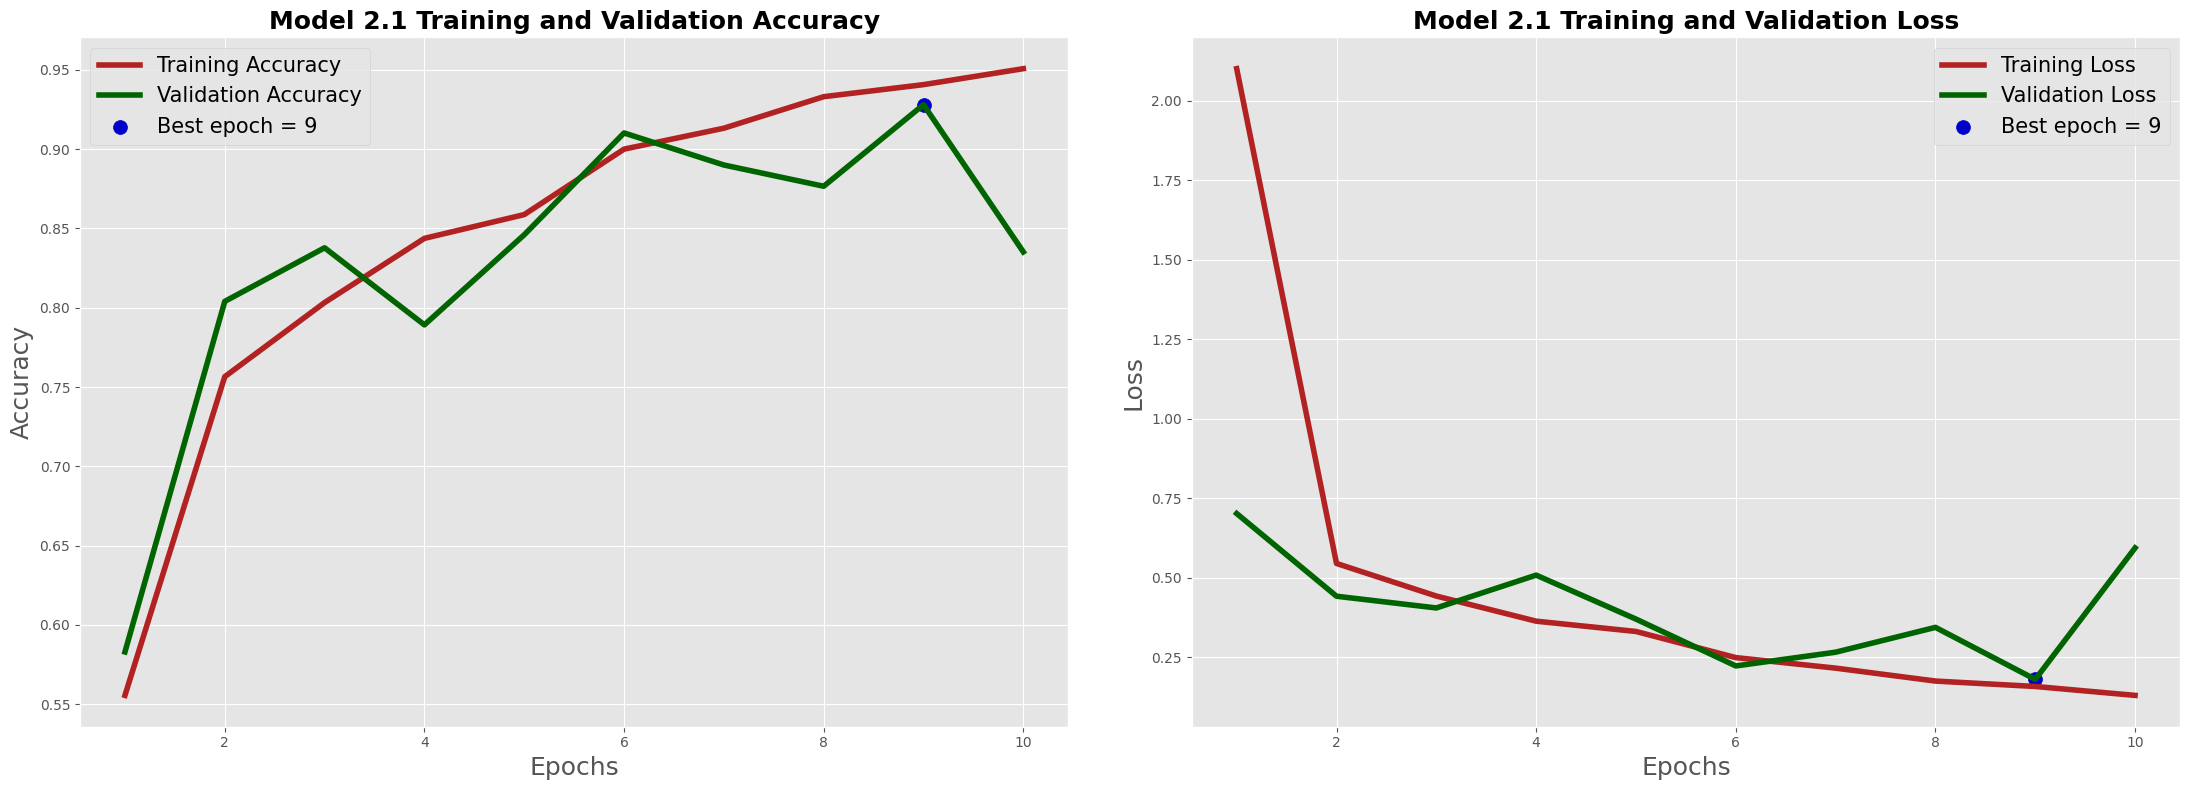

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.92      0.69      0.79      1000
        Colon adenocarcinoma       0.75      0.92      0.83      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.71      0.98      0.82      1000
         Lung adenocarcinoma       0.95      0.59      0.73      1000

                    accuracy                           0.84      5000
                   macro avg       0.86      0.84      0.83      5000
                weighted avg       0.86      0.84      0.83      5000



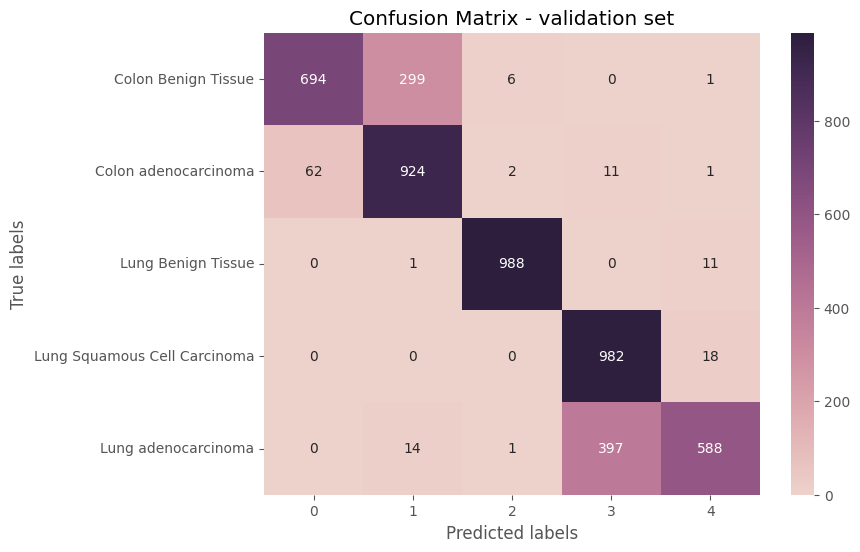

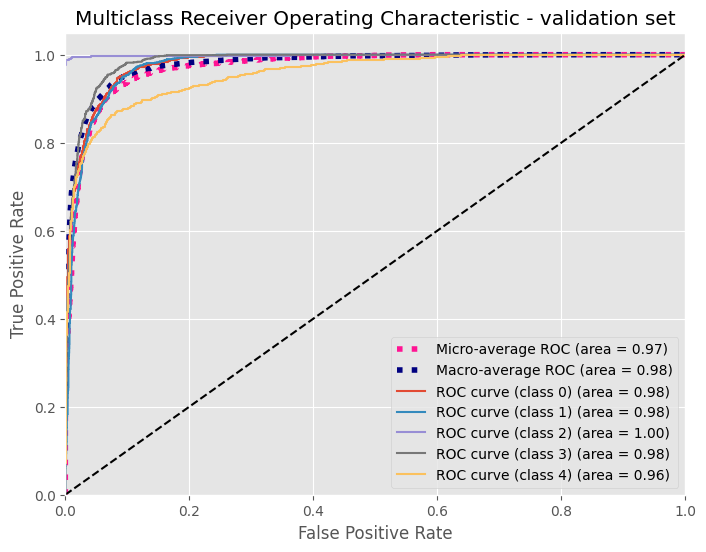

In [ ]:
plot_history(history, 'Model 2.1')
plot_cm(model2, X_val, y_val, 'validation')
plot_roc(model2, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model2_1.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 2_2

In [ ]:
# Instantiate the model
model2 = layer_tuning(n_conv=4)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 64)       

In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model2.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 20s 37ms/step - loss: 0.8456 - accuracy: 0.6819 - val_loss: 0.3658 - val_accuracy: 0.8638
Epoch 2/10
469/469 [==============================] - 17s 36ms/step - loss: 0.3639 - accuracy: 0.8510 - val_loss: 0.2148 - val_accuracy: 0.9204
Epoch 3/10
469/469 [==============================] - 18s 39ms/step - loss: 0.2231 - accuracy: 0.9105 - val_loss: 0.2171 - val_accuracy: 0.9170
Epoch 4/10
469/469 [==============================] - 18s 39ms/step - loss: 0.1999 - accuracy: 0.9229 - val_loss: 0.1707 - val_accuracy: 0.9366
Epoch 5/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1685 - accuracy: 0.9375 - val_loss: 0.1896 - val_accuracy: 0.9250
Epoch 6/10
469/469 [==============================] - 18s 38ms/step - loss: 0.1310 - accuracy: 0.9478 - val_loss: 0.1396 - val_accuracy: 0.9462
Epoch 7/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1076 - accuracy: 0.9584 - val_loss: 0.1163 - val_accuracy:

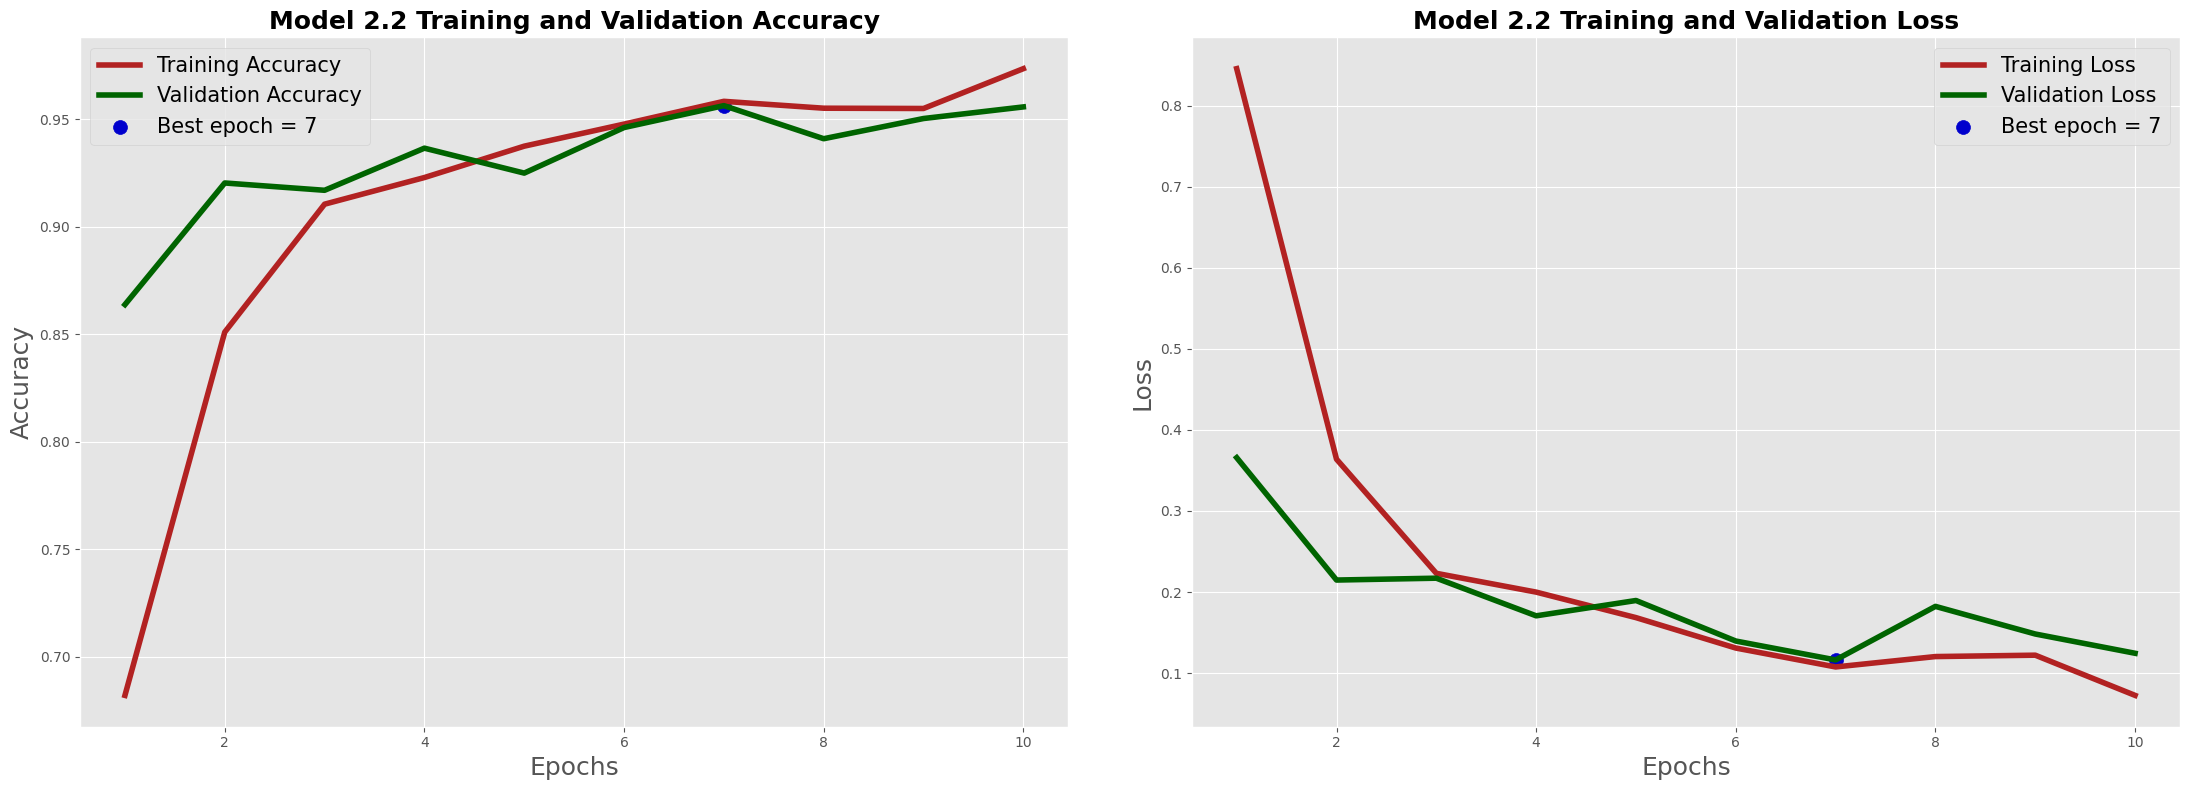

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.95      0.97      1000
        Colon adenocarcinoma       0.95      0.99      0.97      1000
          Lung Benign Tissue       0.98      1.00      0.99      1000
Lung Squamous Cell Carcinoma       0.96      0.90      0.93      1000
         Lung adenocarcinoma       0.90      0.94      0.92      1000

                    accuracy                           0.96      5000
                   macro avg       0.96      0.96      0.96      5000
                weighted avg       0.96      0.96      0.96      5000



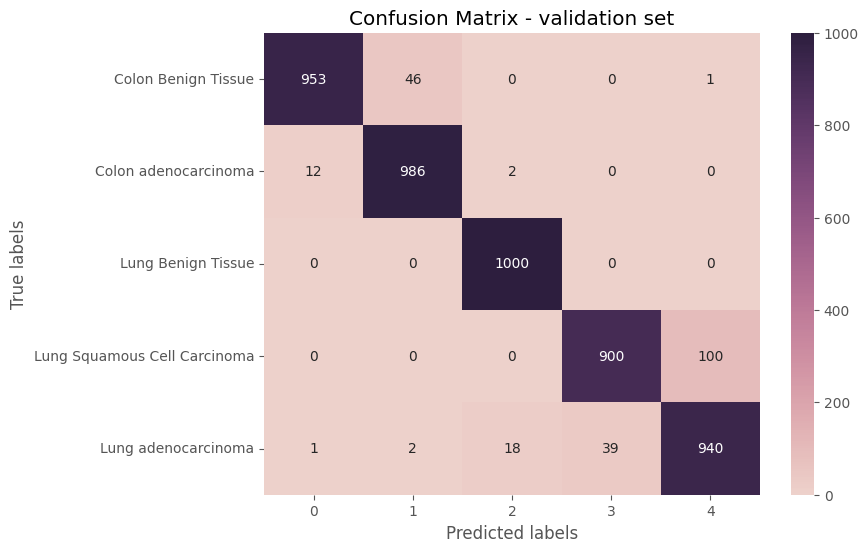

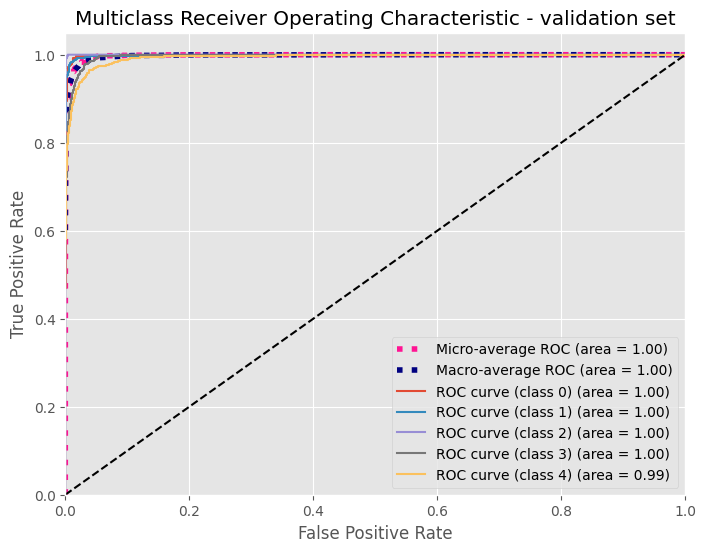

In [ ]:
plot_history(history, 'Model 2.2')
plot_cm(model2, X_val, y_val, 'validation')
plot_roc(model2, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model2_2.pkl', 'wb') as file:
  pickle.dump(results, file)

## Model 3 - neuron numbers

### Model 3_1

In [ ]:
# Define the neuron-tuning model
def neurons(n1=128, n2=64, n3=64, n4=64, n_classes=n_classes,
            input_shape=X_train.shape[1:]):
    model = models.Sequential()
    model.add(layers.Conv2D(n1, (3, 3), activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(n2, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(n3, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(n4, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

# Instantiate the model
model3 = neurons(256, 128, 64, 32)

# Compile the model
model3.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model3.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 43s 82ms/step - loss: 1.1345 - accuracy: 0.6394 - val_loss: 0.4475 - val_accuracy: 0.7528
Epoch 2/10
469/469 [==============================] - 31s 66ms/step - loss: 0.4104 - accuracy: 0.8206 - val_loss: 0.3015 - val_accuracy: 0.8796
Epoch 3/10
469/469 [==============================] - 35s 74ms/step - loss: 0.2678 - accuracy: 0.8915 - val_loss: 0.2226 - val_accuracy: 0.9112
Epoch 4/10
469/469 [==============================] - 31s 66ms/step - loss: 0.1959 - accuracy: 0.9235 - val_loss: 0.2100 - val_accuracy: 0.9118
Epoch 5/10
469/469 [==============================] - 32s 69ms/step - loss: 0.1703 - accuracy: 0.9332 - val_loss: 0.1834 - val_accuracy: 0.9242
Epoch 6/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1456 - accuracy: 0.9424 - val_loss: 0.1794 - val_accuracy: 0.9346
Epoch 7/10
469/469 [==============================] - 31s 65ms/step - loss: 0.1450 - accuracy: 0.9439 - val_loss: 0.1336 - val_accuracy:

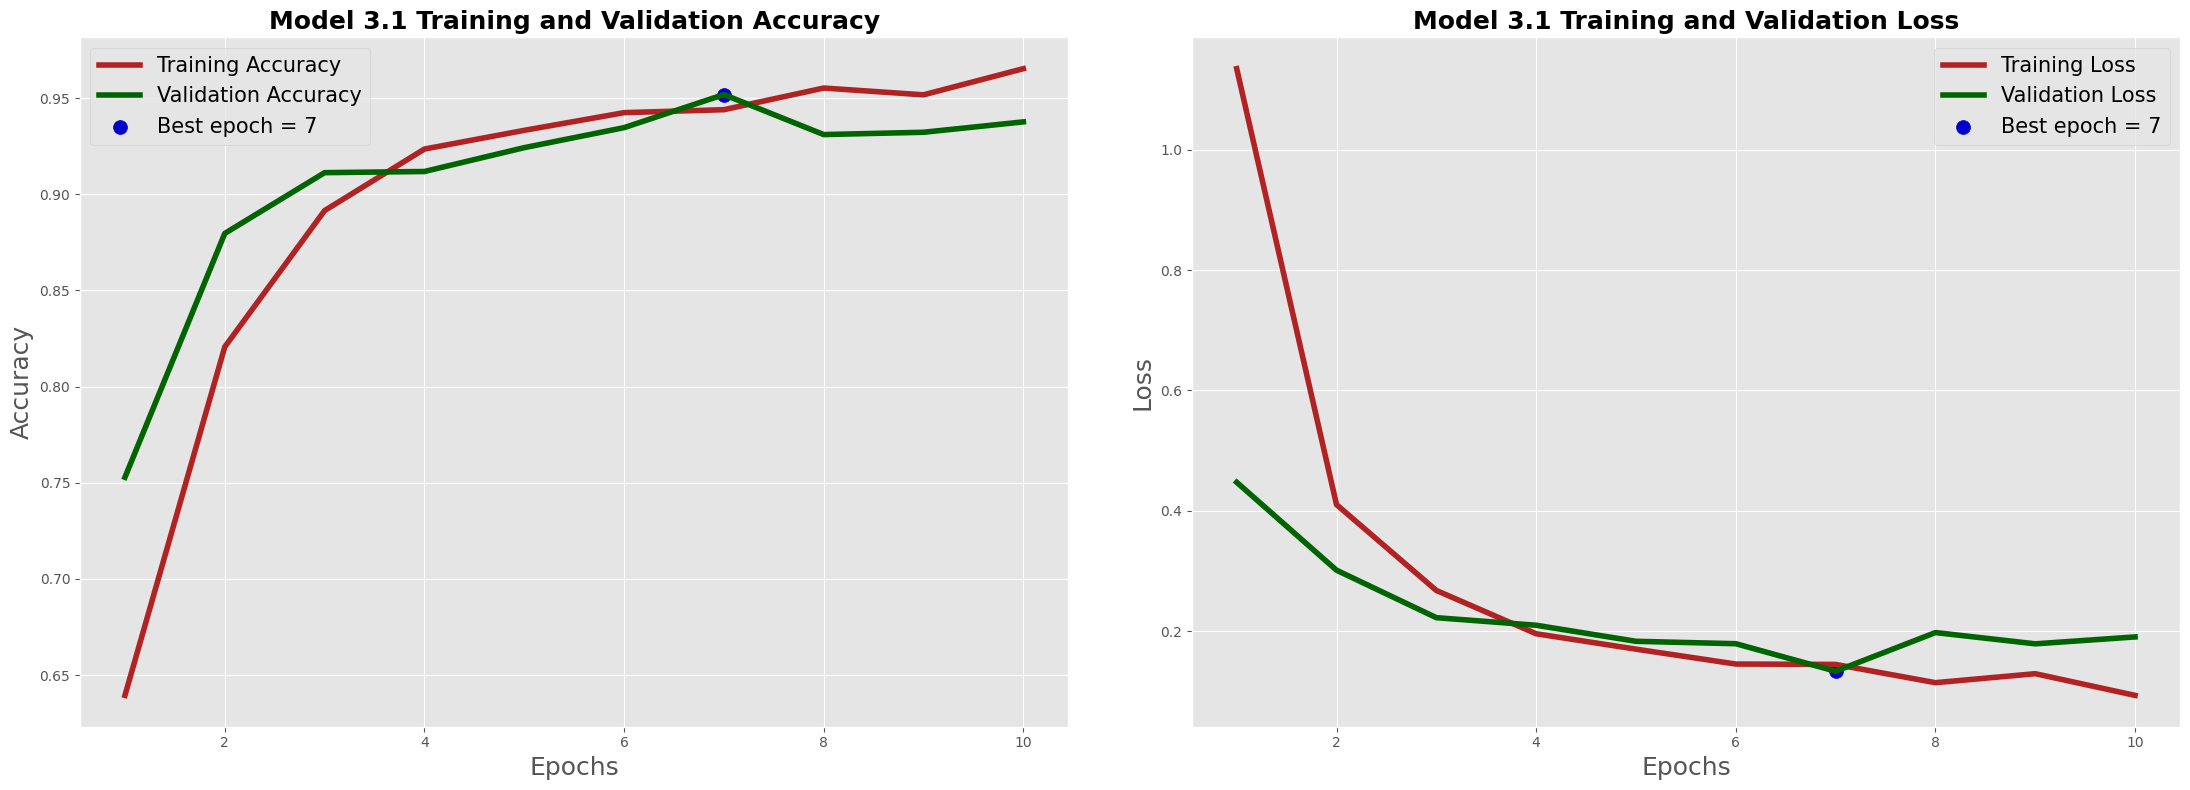

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.88      1.00      0.94      1000
        Colon adenocarcinoma       0.97      0.87      0.92      1000
          Lung Benign Tissue       0.98      1.00      0.99      1000
Lung Squamous Cell Carcinoma       0.93      0.93      0.93      1000
         Lung adenocarcinoma       0.94      0.90      0.92      1000

                    accuracy                           0.94      5000
                   macro avg       0.94      0.94      0.94      5000
                weighted avg       0.94      0.94      0.94      5000



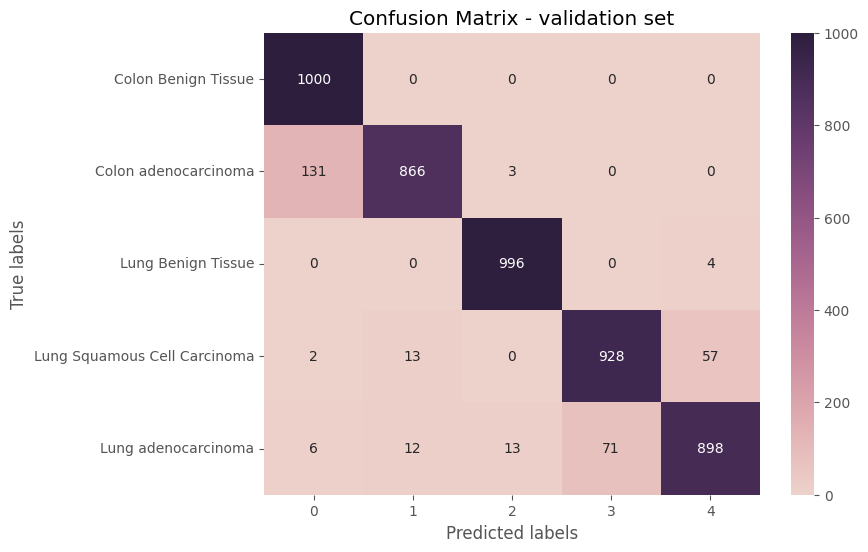

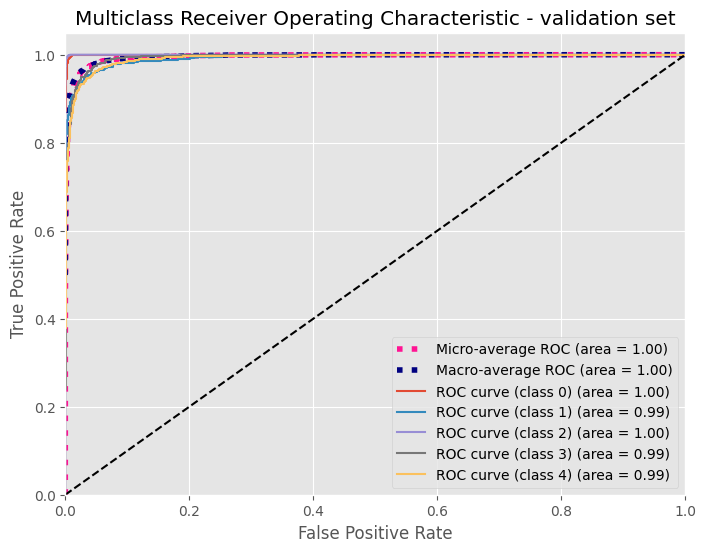

In [ ]:
plot_history(history, 'Model 3.1')
plot_cm(model3, X_val, y_val, 'validation')
plot_roc(model3, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model3_1.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 3_2

In [ ]:
# Instantiate the model
model3 = neurons(32, 64, 128, 256)

# Compile the model
model3.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 15s 26ms/step - loss: 1.4528 - accuracy: 0.7435 - val_loss: 0.2588 - val_accuracy: 0.9040
Epoch 2/10
469/469 [==============================] - 13s 28ms/step - loss: 0.2706 - accuracy: 0.8913 - val_loss: 0.1903 - val_accuracy: 0.9260
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.1656 - accuracy: 0.9336 - val_loss: 0.1411 - val_accuracy: 0.9422
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1382 - accuracy: 0.9447 - val_loss: 0.1011 - val_accuracy: 0.9598
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1181 - accuracy: 0.9540 - val_loss: 0.3287 - val_accuracy: 0.8762
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1235 - accuracy: 0.9523 - val_loss: 0.0926 - val_accuracy: 0.9646
Epoch 7/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0943 - accuracy: 0.9643 - val_loss: 0.1352 - val_accuracy: 0.9

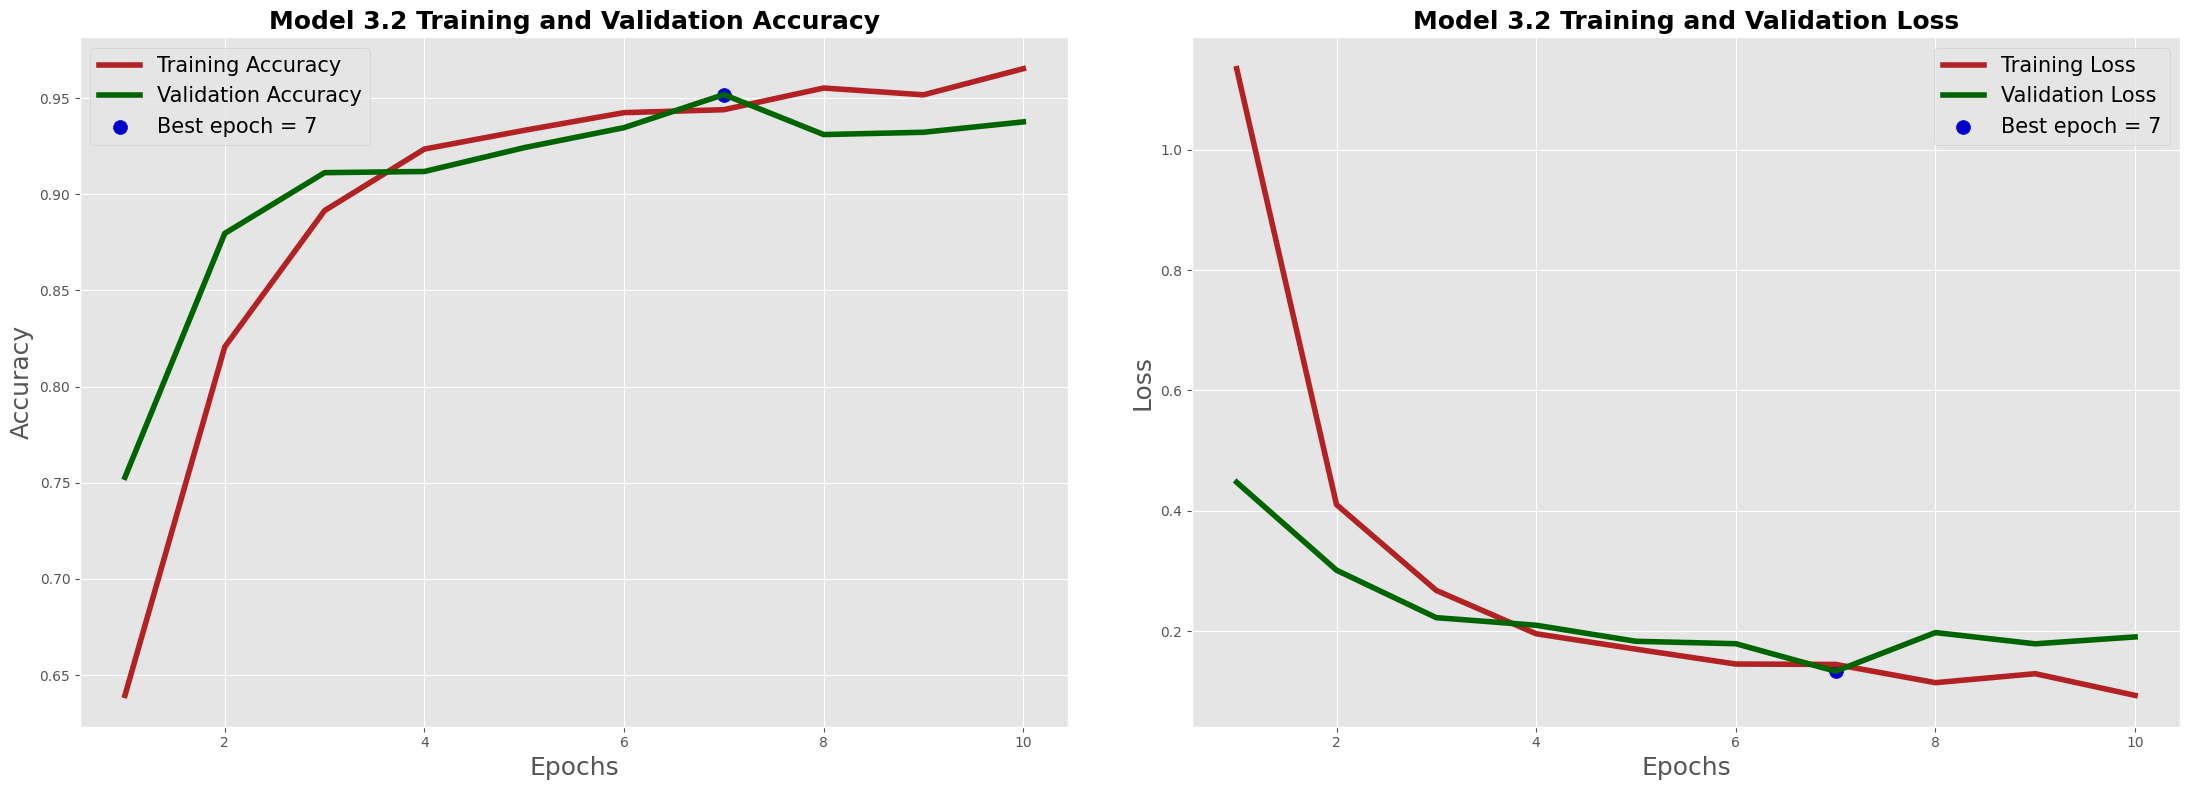

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.99      0.99      1000
        Colon adenocarcinoma       0.98      0.99      0.99      1000
          Lung Benign Tissue       1.00      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.98      0.89      0.93      1000
         Lung adenocarcinoma       0.90      0.97      0.94      1000

                    accuracy                           0.97      5000
                   macro avg       0.97      0.97      0.97      5000
                weighted avg       0.97      0.97      0.97      5000



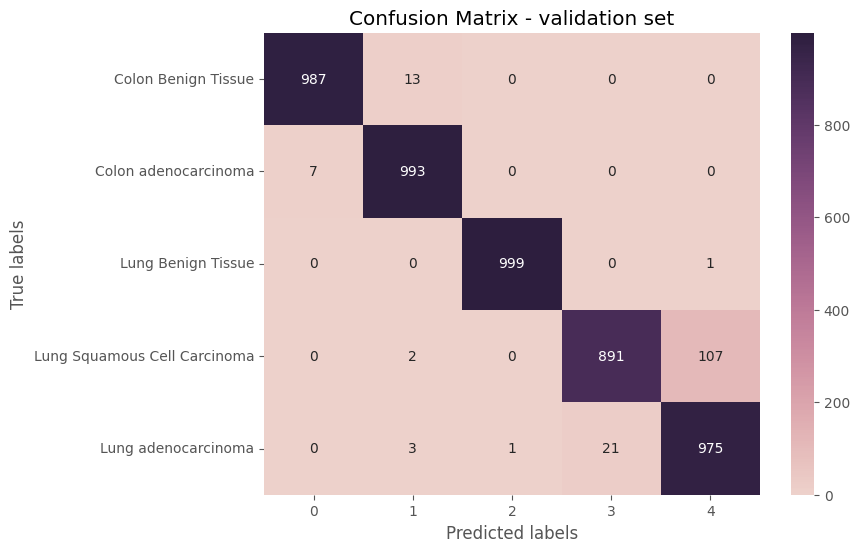

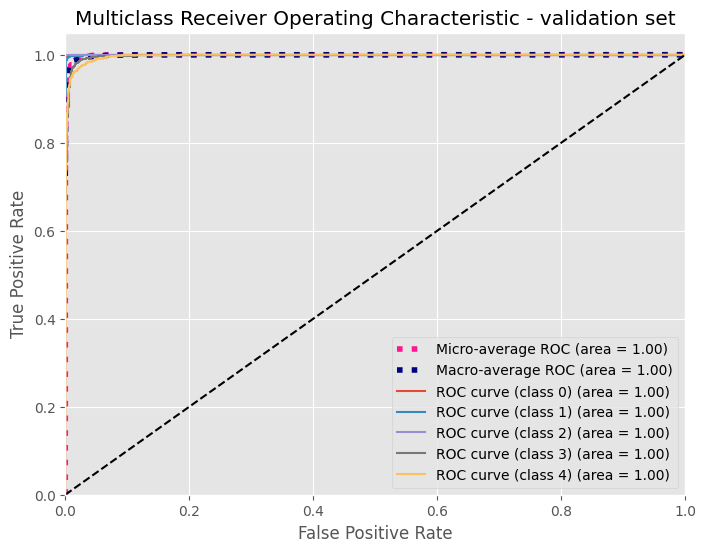

In [ ]:
plot_history(history, 'Model 3.2')
plot_cm(model3, X_val, y_val, 'validation')
plot_roc(model3, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model3_2.pkl', 'wb') as file:
  pickle.dump(results, file)

## Model 4 - kernel size

In [ ]:
# Define the kernel size-tuning model
def kernel_size(k1=(3, 3), s1=(1, 1), n_classes=n_classes, input_shape=X_train.shape[1:]):
    model = models.Sequential()
    model.add(layers.Conv2D(32, k1, strides=s1, activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))
    return model

### Model 4_1

In [ ]:
# Instantiate the model
model4 = kernel_size((5, 5), (2, 2))

# Compile the model
model4.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model4.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 10s 12ms/step - loss: 0.9097 - accuracy: 0.7157 - val_loss: 0.3185 - val_accuracy: 0.8878
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3329 - accuracy: 0.8719 - val_loss: 0.2867 - val_accuracy: 0.8892
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2309 - accuracy: 0.9127 - val_loss: 0.2063 - val_accuracy: 0.9218
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1792 - accuracy: 0.9325 - val_loss: 0.2010 - val_accuracy: 0.9190
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1279 - accuracy: 0.9524 - val_loss: 0.1190 - val_accuracy: 0.9550
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1053 - accuracy: 0.9597 - val_loss: 0.1076 - val_accuracy: 0.9620
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1005 - accuracy: 0.9611 - val_loss: 0.1613 - val_accuracy: 0.9404
Epo

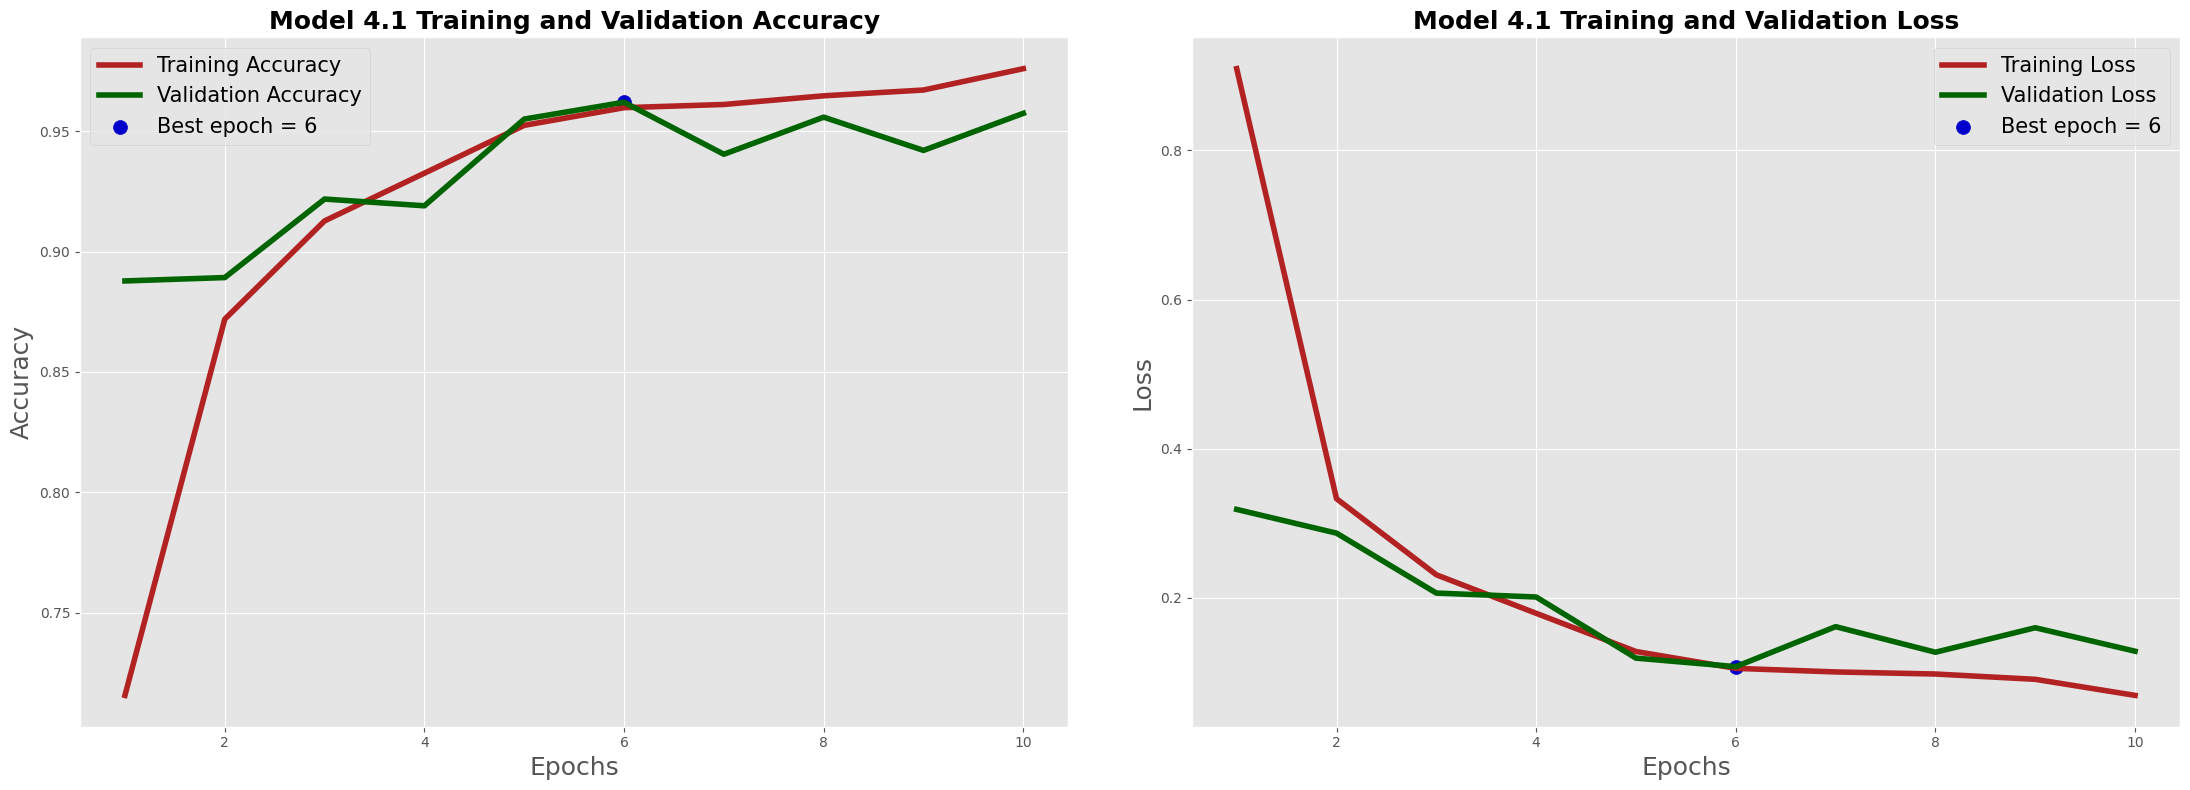

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.98      0.99      1000
        Colon adenocarcinoma       0.98      0.96      0.97      1000
          Lung Benign Tissue       1.00      0.97      0.99      1000
Lung Squamous Cell Carcinoma       0.94      0.93      0.94      1000
         Lung adenocarcinoma       0.88      0.95      0.91      1000

                    accuracy                           0.96      5000
                   macro avg       0.96      0.96      0.96      5000
                weighted avg       0.96      0.96      0.96      5000



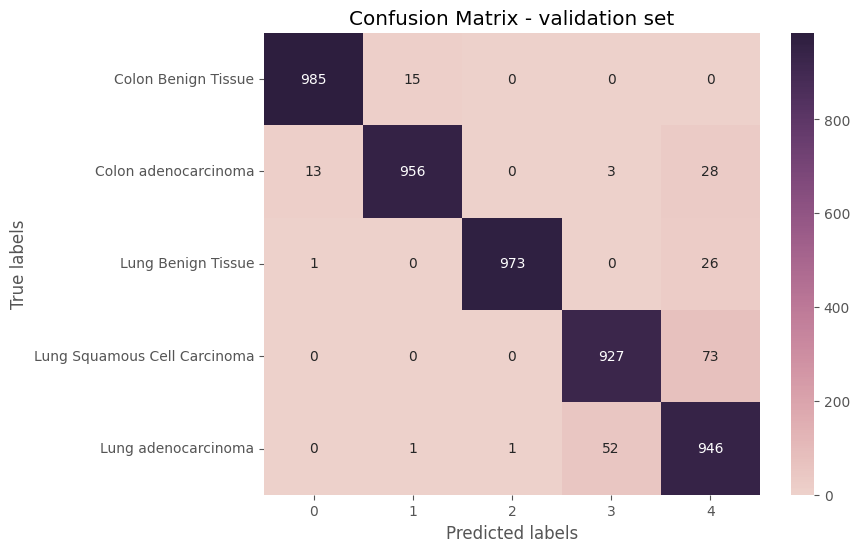

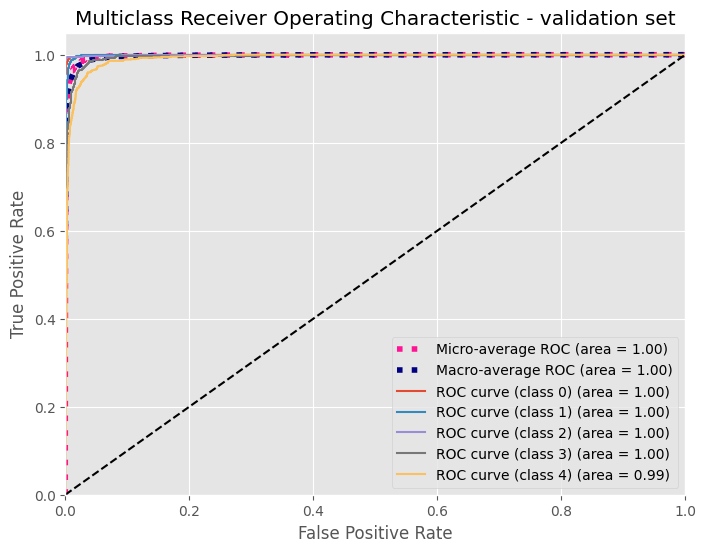

In [ ]:
plot_history(history, 'Model 4.1')
plot_cm(model4, X_val, y_val, 'validation')
plot_roc(model4, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model4_1.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 4_2

In [ ]:
# Instantiate the model
model4 = kernel_size((5, 5), (1, 1))

# Compile the model
model4.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model4.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 18s 27ms/step - loss: 1.0518 - accuracy: 0.7183 - val_loss: 0.3726 - val_accuracy: 0.8554
Epoch 2/10
469/469 [==============================] - 14s 29ms/step - loss: 0.3286 - accuracy: 0.8631 - val_loss: 0.2272 - val_accuracy: 0.9176
Epoch 3/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1837 - accuracy: 0.9290 - val_loss: 0.1626 - val_accuracy: 0.9360
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1504 - accuracy: 0.9435 - val_loss: 0.1515 - val_accuracy: 0.9376
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1174 - accuracy: 0.9553 - val_loss: 0.1780 - val_accuracy: 0.9400
Epoch 6/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1123 - accuracy: 0.9593 - val_loss: 0.2287 - val_accuracy: 0.9204
Epoch 7/10
469/469 [==============================] - 10s 20ms/step - loss: 0.1171 - accuracy: 0.9577 - val_loss: 0.1342 - val_accuracy:

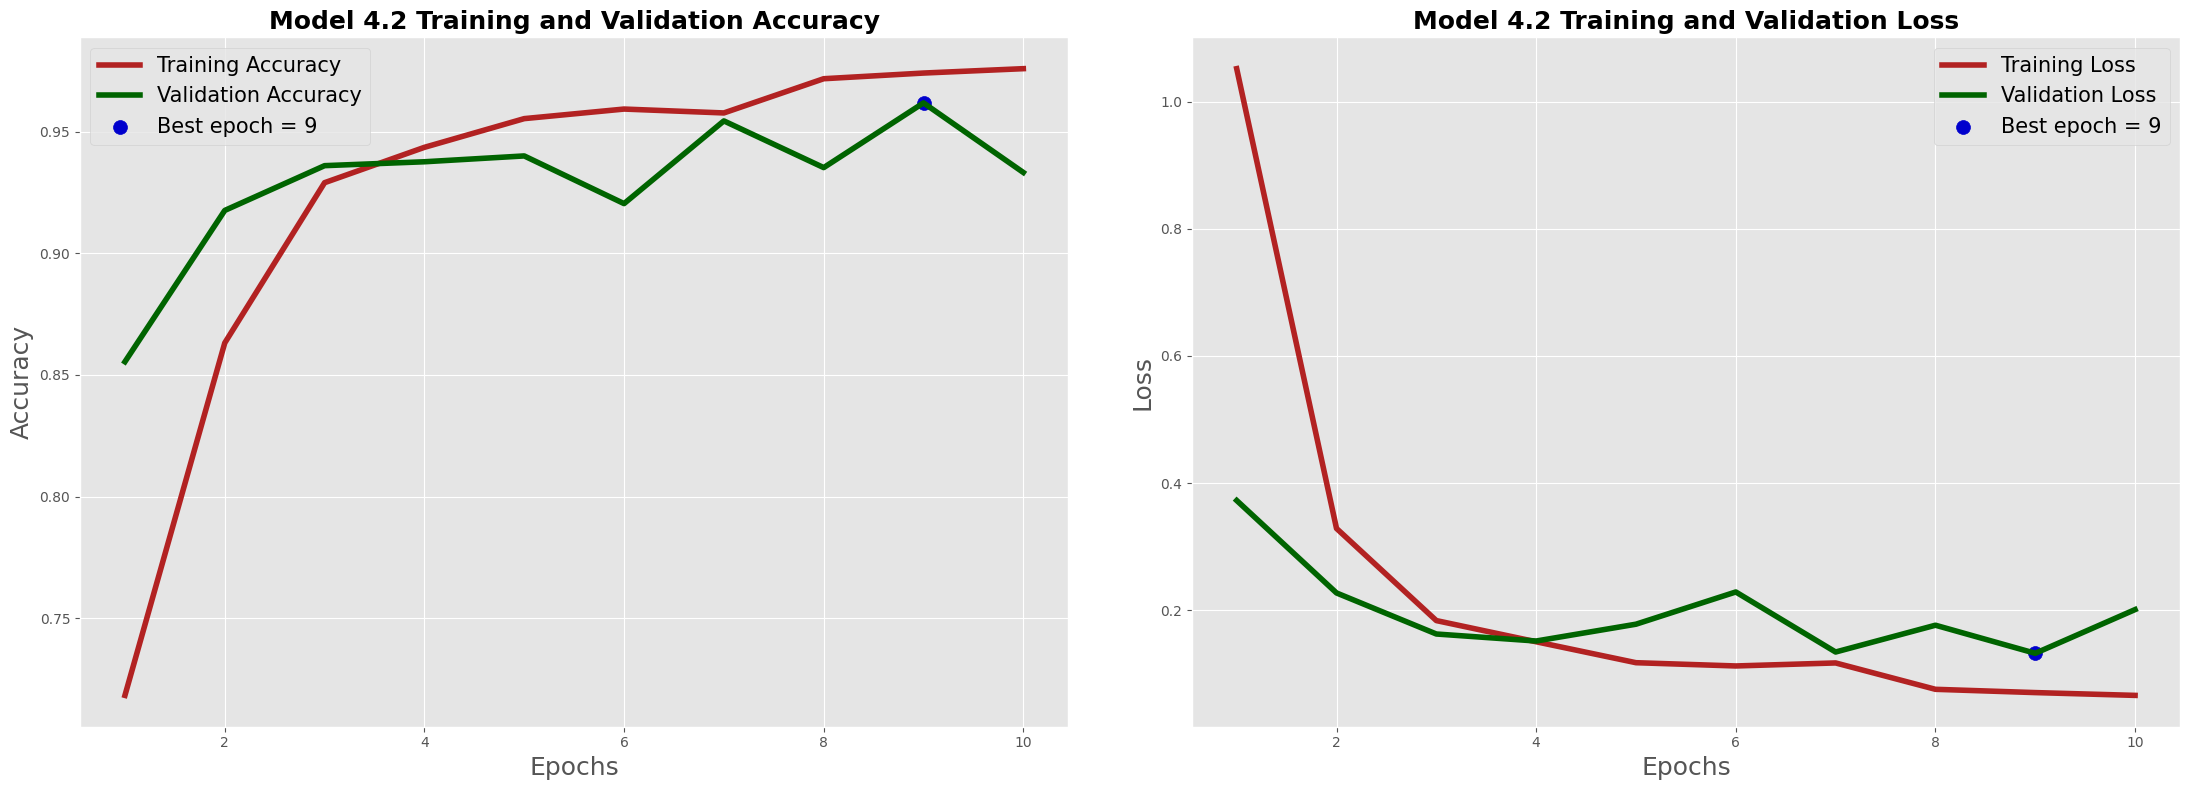

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.94      0.96      0.95      1000
        Colon adenocarcinoma       0.99      0.90      0.94      1000
          Lung Benign Tissue       0.95      0.99      0.97      1000
Lung Squamous Cell Carcinoma       0.85      0.98      0.91      1000
         Lung adenocarcinoma       0.95      0.83      0.89      1000

                    accuracy                           0.93      5000
                   macro avg       0.94      0.93      0.93      5000
                weighted avg       0.94      0.93      0.93      5000



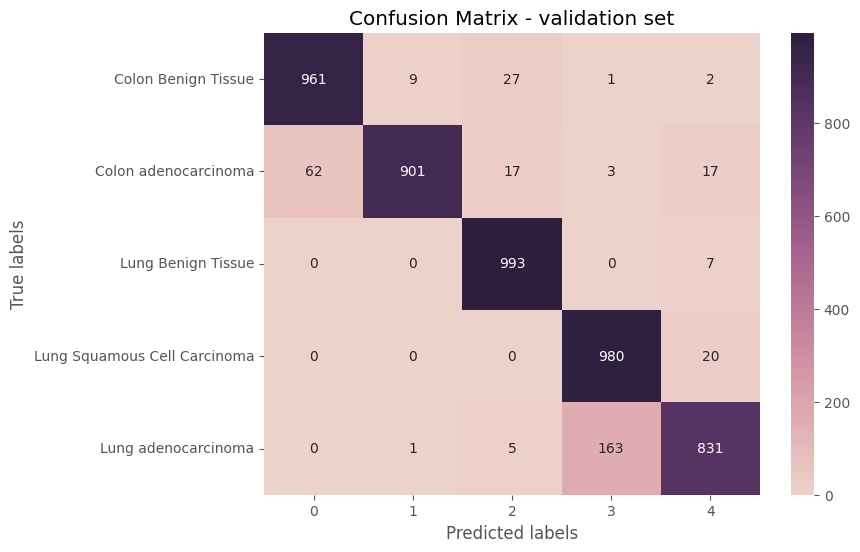

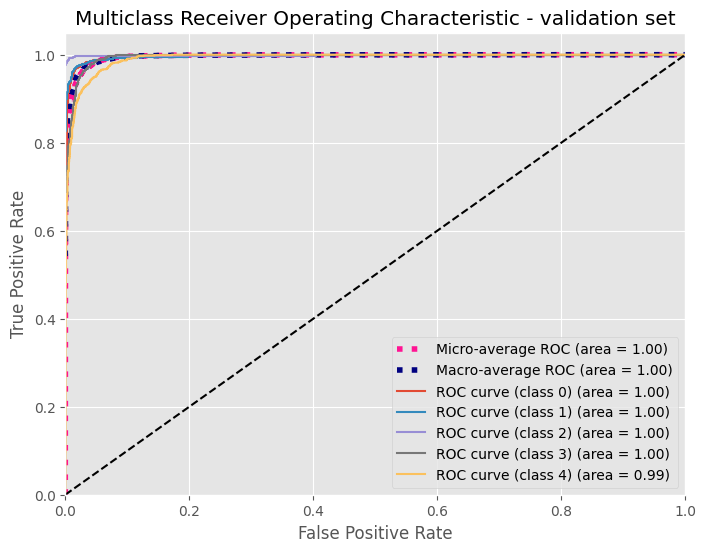

In [ ]:
plot_history(history, 'Model 4.2')
plot_cm(model4, X_val, y_val, 'validation')
plot_roc(model4, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model4_2.pkl', 'wb') as file:
  pickle.dump(results, file)

## Model 5 - batch size

In [ ]:
# Instantiate the model
model5 = kernel_size((5, 5), (2, 2))

### Model 5_1: Batch64

In [ ]:
# Compile the model
model5.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model5.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
235/235 [==============================] - 8s 16ms/step - loss: 1.4458 - accuracy: 0.6260 - val_loss: 0.6483 - val_accuracy: 0.6728
Epoch 2/10
235/235 [==============================] - 4s 19ms/step - loss: 0.4698 - accuracy: 0.8032 - val_loss: 0.3357 - val_accuracy: 0.8584
Epoch 3/10
235/235 [==============================] - 4s 16ms/step - loss: 0.3023 - accuracy: 0.8790 - val_loss: 0.2491 - val_accuracy: 0.9090
Epoch 4/10
235/235 [==============================] - 4s 17ms/step - loss: 0.2421 - accuracy: 0.9077 - val_loss: 0.1705 - val_accuracy: 0.9326
Epoch 5/10
235/235 [==============================] - 5s 20ms/step - loss: 0.1787 - accuracy: 0.9313 - val_loss: 0.2230 - val_accuracy: 0.9252
Epoch 6/10
235/235 [==============================] - 4s 16ms/step - loss: 0.1450 - accuracy: 0.9444 - val_loss: 0.1354 - val_accuracy: 0.9470
Epoch 7/10
235/235 [==============================] - 4s 17ms/step - loss: 0.1328 - accuracy: 0.9500 - val_loss: 0.3361 - val_accuracy: 0.8838

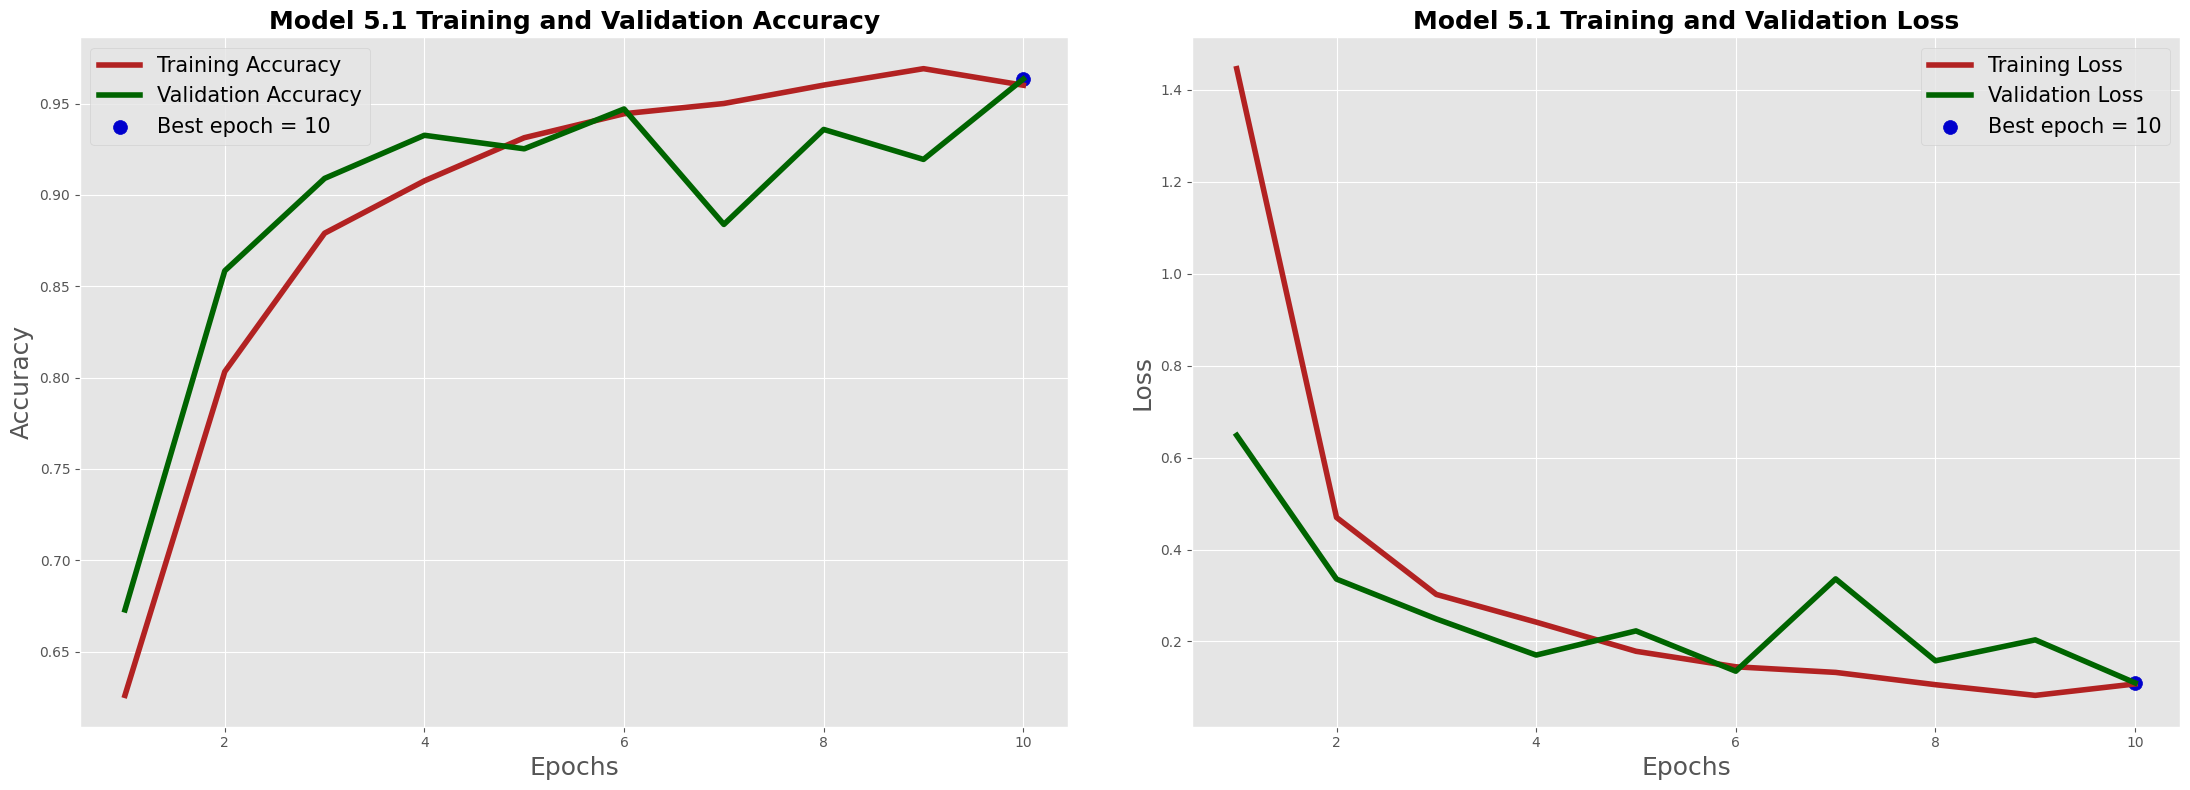

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.98      0.97      0.98      1000
        Colon adenocarcinoma       0.97      0.98      0.98      1000
          Lung Benign Tissue       0.99      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.96      0.91      0.94      1000
         Lung adenocarcinoma       0.91      0.95      0.93      1000

                    accuracy                           0.96      5000
                   macro avg       0.96      0.96      0.96      5000
                weighted avg       0.96      0.96      0.96      5000



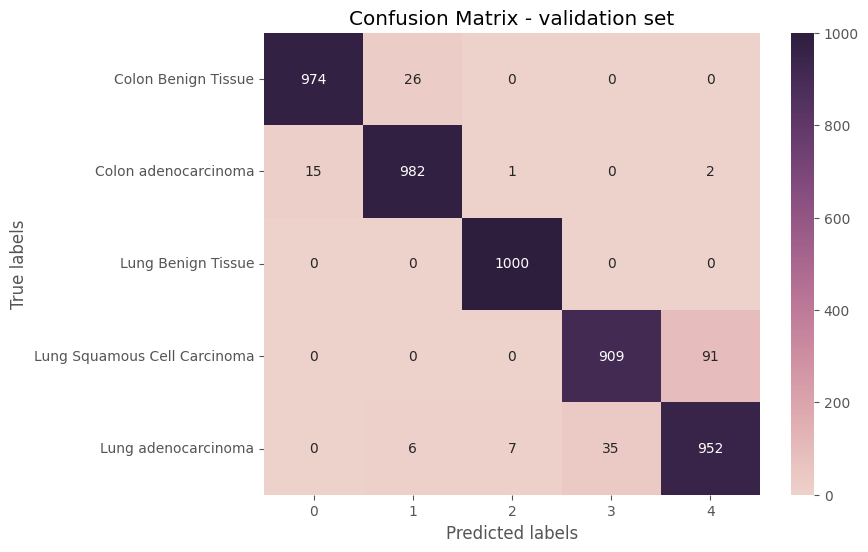

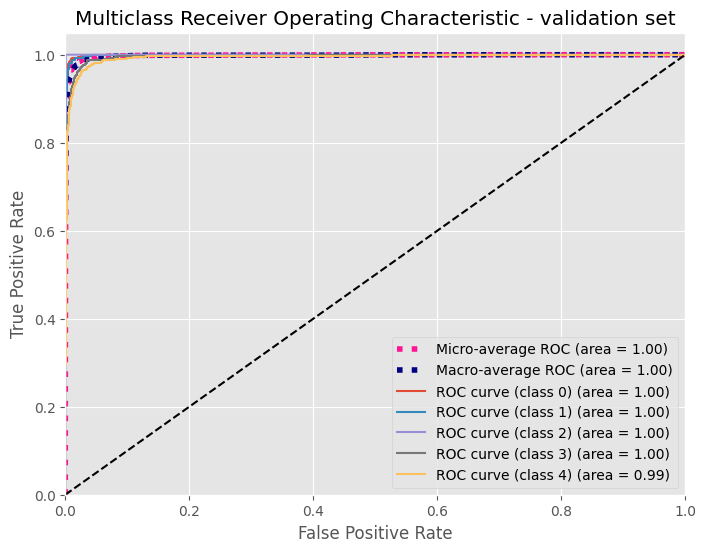

In [ ]:
plot_history(history, 'Model 5.1')
plot_cm(model5, X_val, y_val, 'validation')
plot_roc(model5, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model5_1.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 5_2: Batch128

In [ ]:
# Compile the model
model5.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model5.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 8s 33ms/step - loss: 0.0989 - accuracy: 0.9773 - val_loss: 0.0889 - val_accuracy: 0.9744
Epoch 2/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.1031 - val_accuracy: 0.9714
Epoch 3/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0636 - accuracy: 0.9772 - val_loss: 0.1170 - val_accuracy: 0.9636
Epoch 4/10
118/118 [==============================] - 3s 28ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0747 - val_accuracy: 0.9786
Epoch 5/10
118/118 [==============================] - 3s 27ms/step - loss: 0.0169 - accuracy: 0.9943 - val_loss: 0.1116 - val_accuracy: 0.9714
Epoch 6/10
118/118 [==============================] - 3s 23ms/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.0784 - val_accuracy: 0.9784
Epoch 7/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0472 - accuracy: 0.9837 - val_loss: 0.2722 - val_accuracy: 0.9274

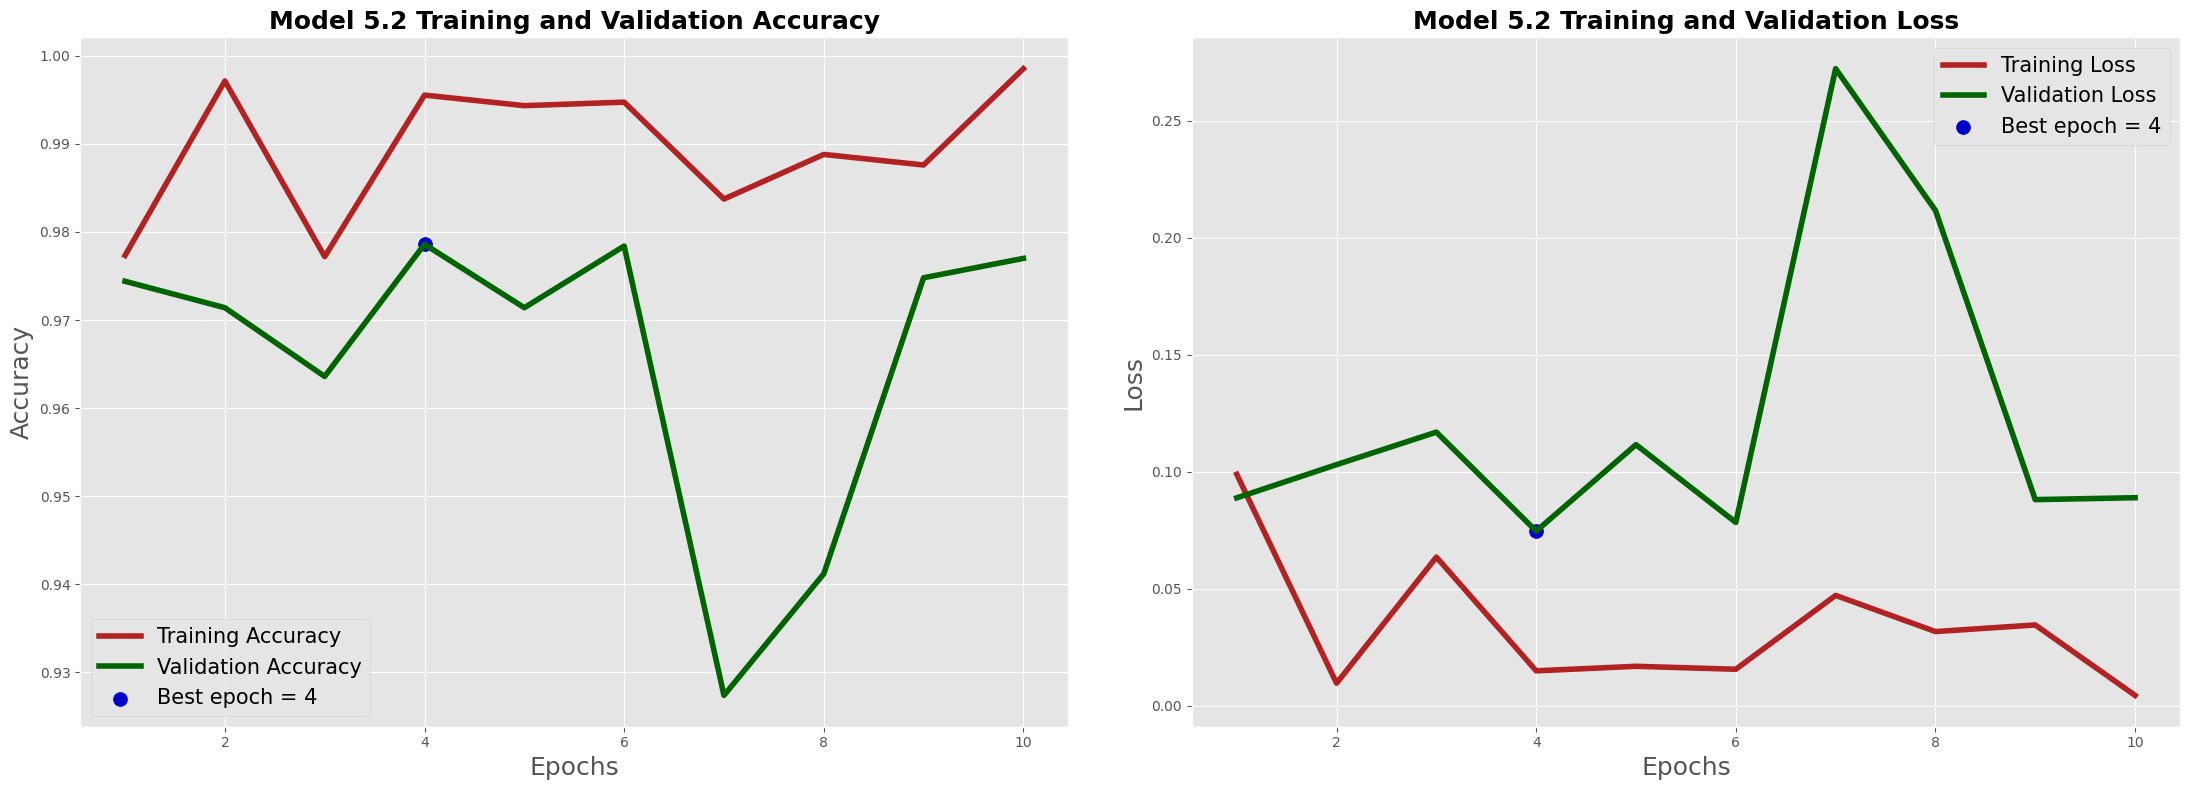

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      0.98      0.99      1000
        Colon adenocarcinoma       0.98      0.99      0.98      1000
          Lung Benign Tissue       1.00      0.99      1.00      1000
Lung Squamous Cell Carcinoma       0.96      0.96      0.96      1000
         Lung adenocarcinoma       0.95      0.96      0.95      1000

                    accuracy                           0.98      5000
                   macro avg       0.98      0.98      0.98      5000
                weighted avg       0.98      0.98      0.98      5000



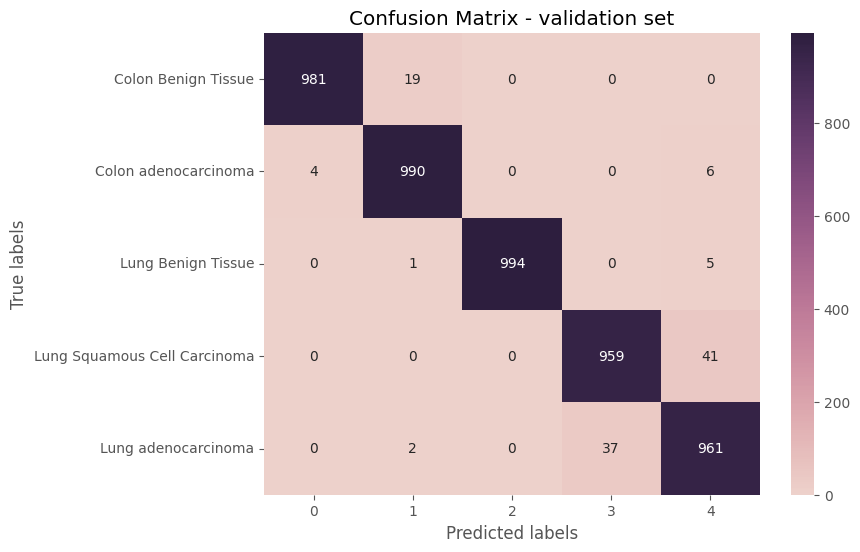

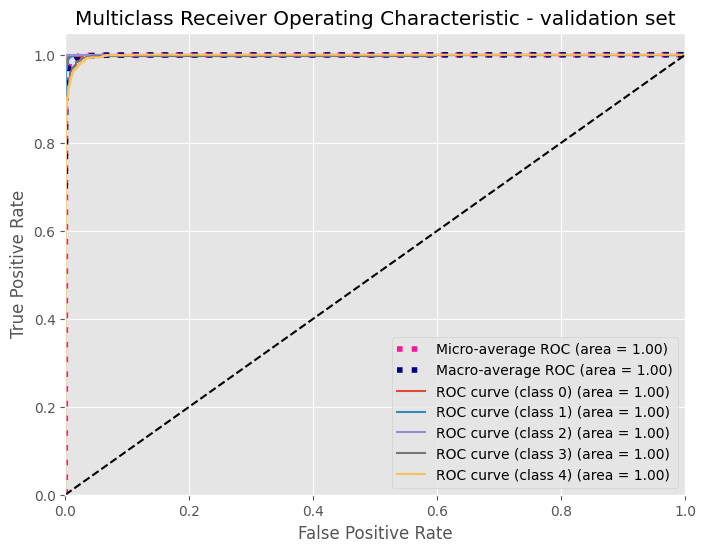

In [ ]:
plot_history(history, 'Model 5.2')
plot_cm(model5, X_val, y_val, 'validation')
plot_roc(model5, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model5_2.pkl', 'wb') as file:
  pickle.dump(results, file)

### Batch normalization layer

In [ ]:
# Define the model with batch normalization layers
# https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns

def batchnorm(n_classes=n_classes, input_shape=X_train.shape[1:]):
    from tensorflow.keras.layers import BatchNormalization

    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                            activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model


# Instantiate the model
model5bn = batchnorm()

model5bn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 batch_normalization_7 (Bat  (None, 60, 60, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 30, 30, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
# Compile the model
model5bn.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history5bn = model5bn.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model5bn.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 12s 36ms/step - loss: 0.2974 - accuracy: 0.8909 - val_loss: 10.3420 - val_accuracy: 0.2208
Epoch 2/10
118/118 [==============================] - 3s 28ms/step - loss: 0.1230 - accuracy: 0.9567 - val_loss: 1.7760 - val_accuracy: 0.4444
Epoch 3/10
118/118 [==============================] - 4s 31ms/step - loss: 0.0883 - accuracy: 0.9673 - val_loss: 2.2350 - val_accuracy: 0.6598
Epoch 4/10
118/118 [==============================] - 4s 31ms/step - loss: 0.0642 - accuracy: 0.9777 - val_loss: 1.2647 - val_accuracy: 0.6886
Epoch 5/10
118/118 [==============================] - 3s 28ms/step - loss: 0.0498 - accuracy: 0.9821 - val_loss: 2.5389 - val_accuracy: 0.5702
Epoch 6/10
118/118 [==============================] - 4s 30ms/step - loss: 0.0371 - accuracy: 0.9869 - val_loss: 1.3123 - val_accuracy: 0.7634
Epoch 7/10
118/118 [==============================] - 4s 31ms/step - loss: 0.0408 - accuracy: 0.9860 - val_loss: 1.2416 - val_accuracy: 0.80

In [ ]:
# Save the results
results = {'history': history5bn.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model5_3.pkl', 'wb') as file:
  pickle.dump(results, file)

## Model 6 - optimizers

In [ ]:
# Instantiate the model
model6 = kernel_size((5, 5), (2, 2))

### Adam lower learning rate

In [ ]:
# Compile the model
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model6.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 6s 33ms/step - loss: 2.5635 - accuracy: 0.3101 - val_loss: 1.1291 - val_accuracy: 0.4712
Epoch 2/10
118/118 [==============================] - 3s 27ms/step - loss: 0.9612 - accuracy: 0.5644 - val_loss: 0.8131 - val_accuracy: 0.6360
Epoch 3/10
118/118 [==============================] - 3s 22ms/step - loss: 0.7453 - accuracy: 0.6732 - val_loss: 0.6635 - val_accuracy: 0.7128
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6274 - accuracy: 0.7323 - val_loss: 0.5855 - val_accuracy: 0.7598
Epoch 5/10
118/118 [==============================] - 3s 22ms/step - loss: 0.5597 - accuracy: 0.7667 - val_loss: 0.5359 - val_accuracy: 0.7822
Epoch 6/10
118/118 [==============================] - 3s 22ms/step - loss: 0.5149 - accuracy: 0.7865 - val_loss: 0.4948 - val_accuracy: 0.7904
Epoch 7/10
118/118 [==============================] - 3s 27ms/step - loss: 0.4797 - accuracy: 0.8011 - val_loss: 0.5029 - val_accuracy: 0.7962

### RMSprop

In [ ]:
# Compile the model
model6.compile(optimizer='rmsprop',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history6 = model6.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 9s 45ms/step - loss: 5.8568 - accuracy: 0.3177 - val_loss: 1.6430 - val_accuracy: 0.2030
Epoch 2/10
118/118 [==============================] - 3s 23ms/step - loss: 1.2094 - accuracy: 0.4582 - val_loss: 0.6654 - val_accuracy: 0.6818
Epoch 3/10
118/118 [==============================] - 3s 22ms/step - loss: 0.7976 - accuracy: 0.6405 - val_loss: 1.4100 - val_accuracy: 0.4686
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6624 - accuracy: 0.7057 - val_loss: 0.5184 - val_accuracy: 0.7178
Epoch 5/10
118/118 [==============================] - 4s 31ms/step - loss: 0.5517 - accuracy: 0.7465 - val_loss: 0.4298 - val_accuracy: 0.7834
Epoch 6/10
118/118 [==============================] - 3s 26ms/step - loss: 0.4955 - accuracy: 0.7817 - val_loss: 0.5027 - val_accuracy: 0.8136
Epoch 7/10
118/118 [==============================] - 3s 24ms/step - loss: 0.7638 - accuracy: 0.7280 - val_loss: 0.9885 - val_accuracy: 0.5730

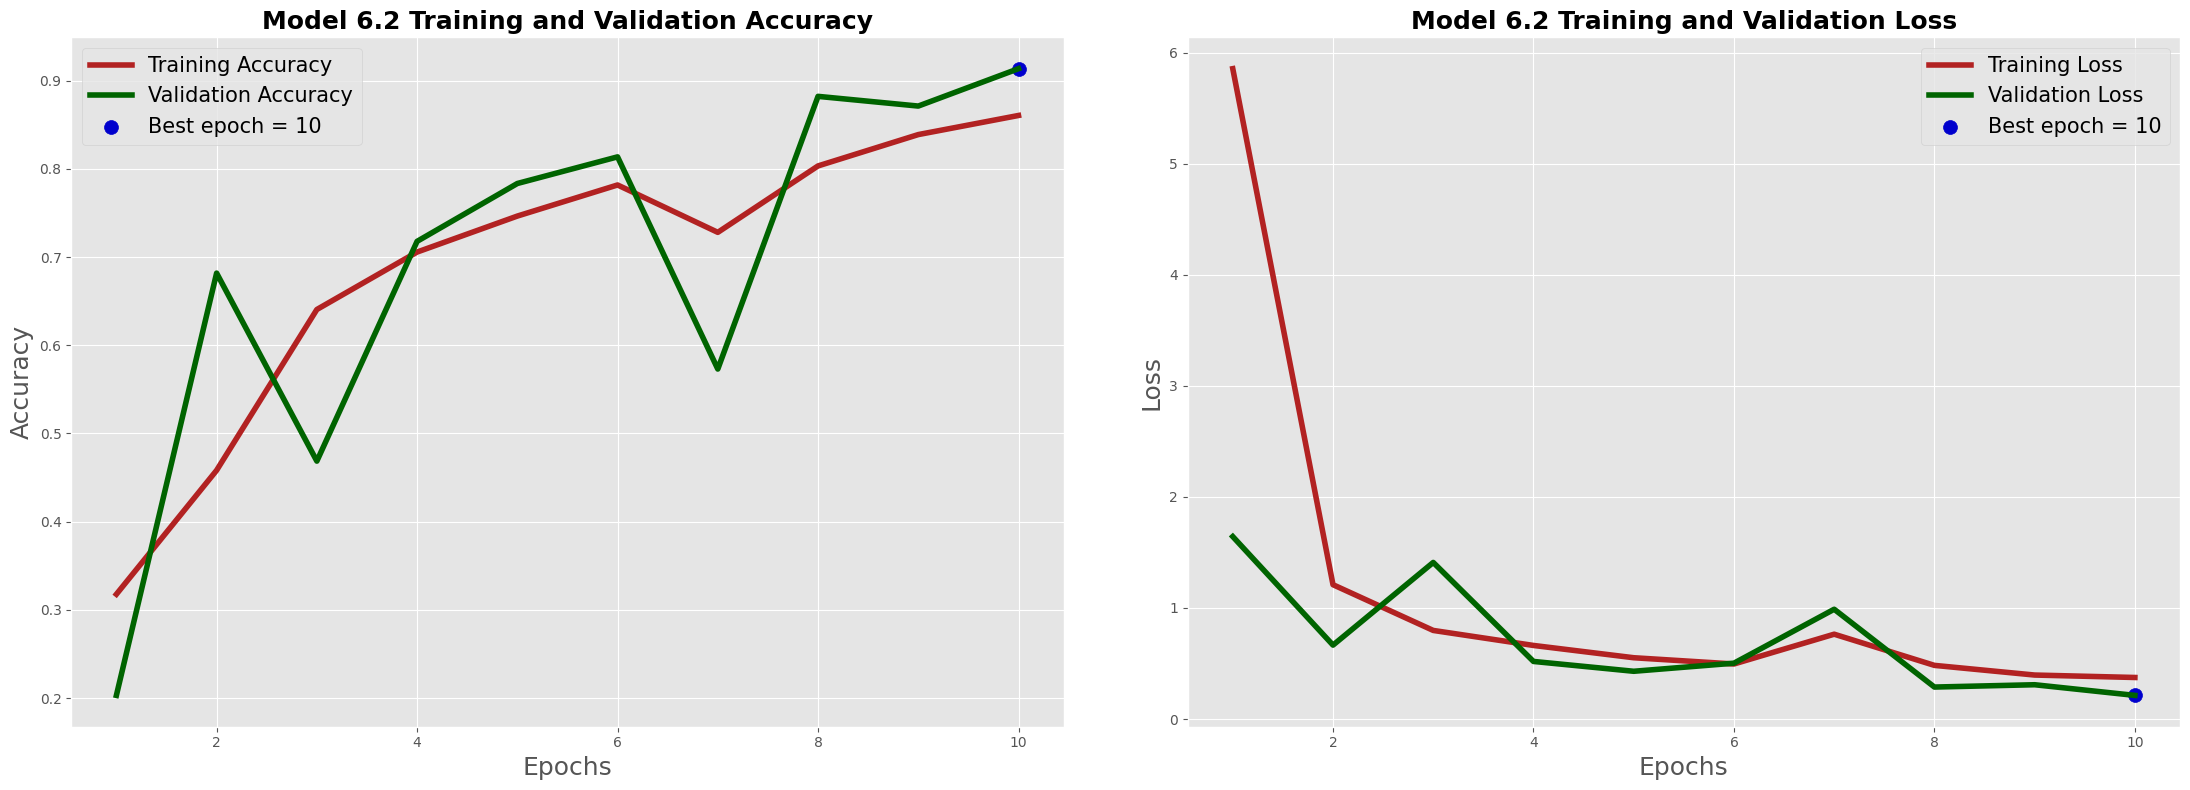

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.92      0.90      0.91      1000
        Colon adenocarcinoma       0.90      0.92      0.91      1000
          Lung Benign Tissue       1.00      0.99      1.00      1000
Lung Squamous Cell Carcinoma       0.95      0.80      0.87      1000
         Lung adenocarcinoma       0.82      0.95      0.88      1000

                    accuracy                           0.91      5000
                   macro avg       0.92      0.91      0.91      5000
                weighted avg       0.92      0.91      0.91      5000



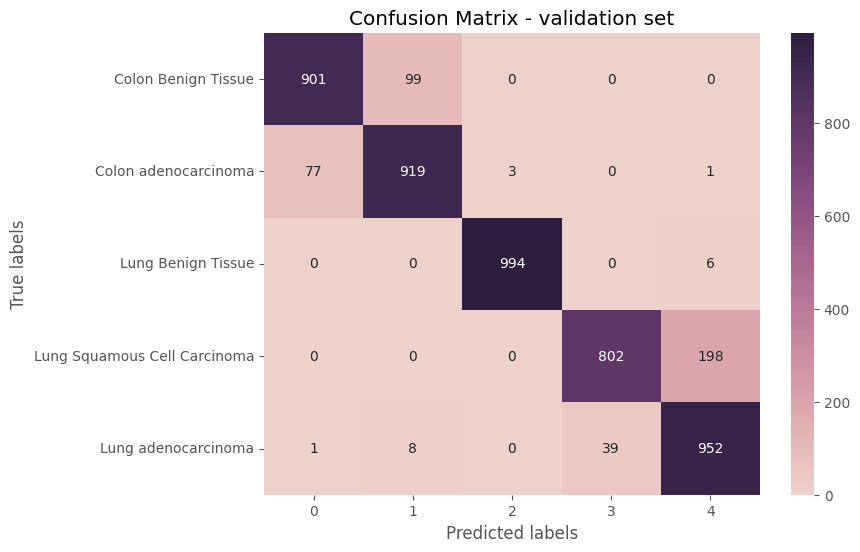

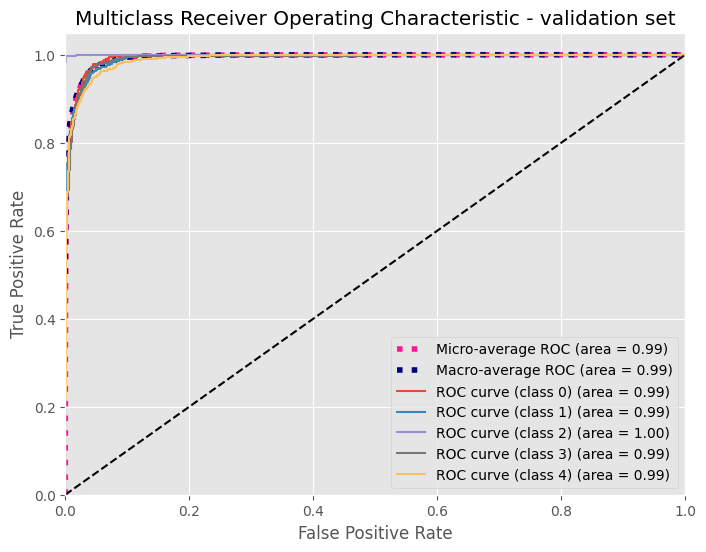

In [ ]:
plot_history(history6, 'Model 6.2')
plot_cm(model6, X_val, y_val, 'validation')
plot_roc(model6, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history6.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model6_2.pkl', 'wb') as file:
  pickle.dump(results, file)

### Adamax

In [ ]:
# Compile the model
model6.compile(optimizer='adamax',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Train the model
history = model6.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 15s 34ms/step - loss: 2.3585 - accuracy: 0.6363 - val_loss: 0.5032 - val_accuracy: 0.7538
Epoch 2/10
118/118 [==============================] - 3s 22ms/step - loss: 0.4084 - accuracy: 0.8321 - val_loss: 0.3837 - val_accuracy: 0.8348
Epoch 3/10
118/118 [==============================] - 3s 27ms/step - loss: 0.3370 - accuracy: 0.8627 - val_loss: 0.3377 - val_accuracy: 0.8584
Epoch 4/10
118/118 [==============================] - 3s 23ms/step - loss: 0.2939 - accuracy: 0.8813 - val_loss: 0.3174 - val_accuracy: 0.8580
Epoch 5/10
118/118 [==============================] - 3s 22ms/step - loss: 0.2586 - accuracy: 0.8957 - val_loss: 0.2882 - val_accuracy: 0.8764
Epoch 6/10
118/118 [==============================] - 3s 26ms/step - loss: 0.2261 - accuracy: 0.9118 - val_loss: 0.2085 - val_accuracy: 0.9162
Epoch 7/10
118/118 [==============================] - 4s 34ms/step - loss: 0.1841 - accuracy: 0.9292 - val_loss: 0.2391 - val_accuracy: 0.904

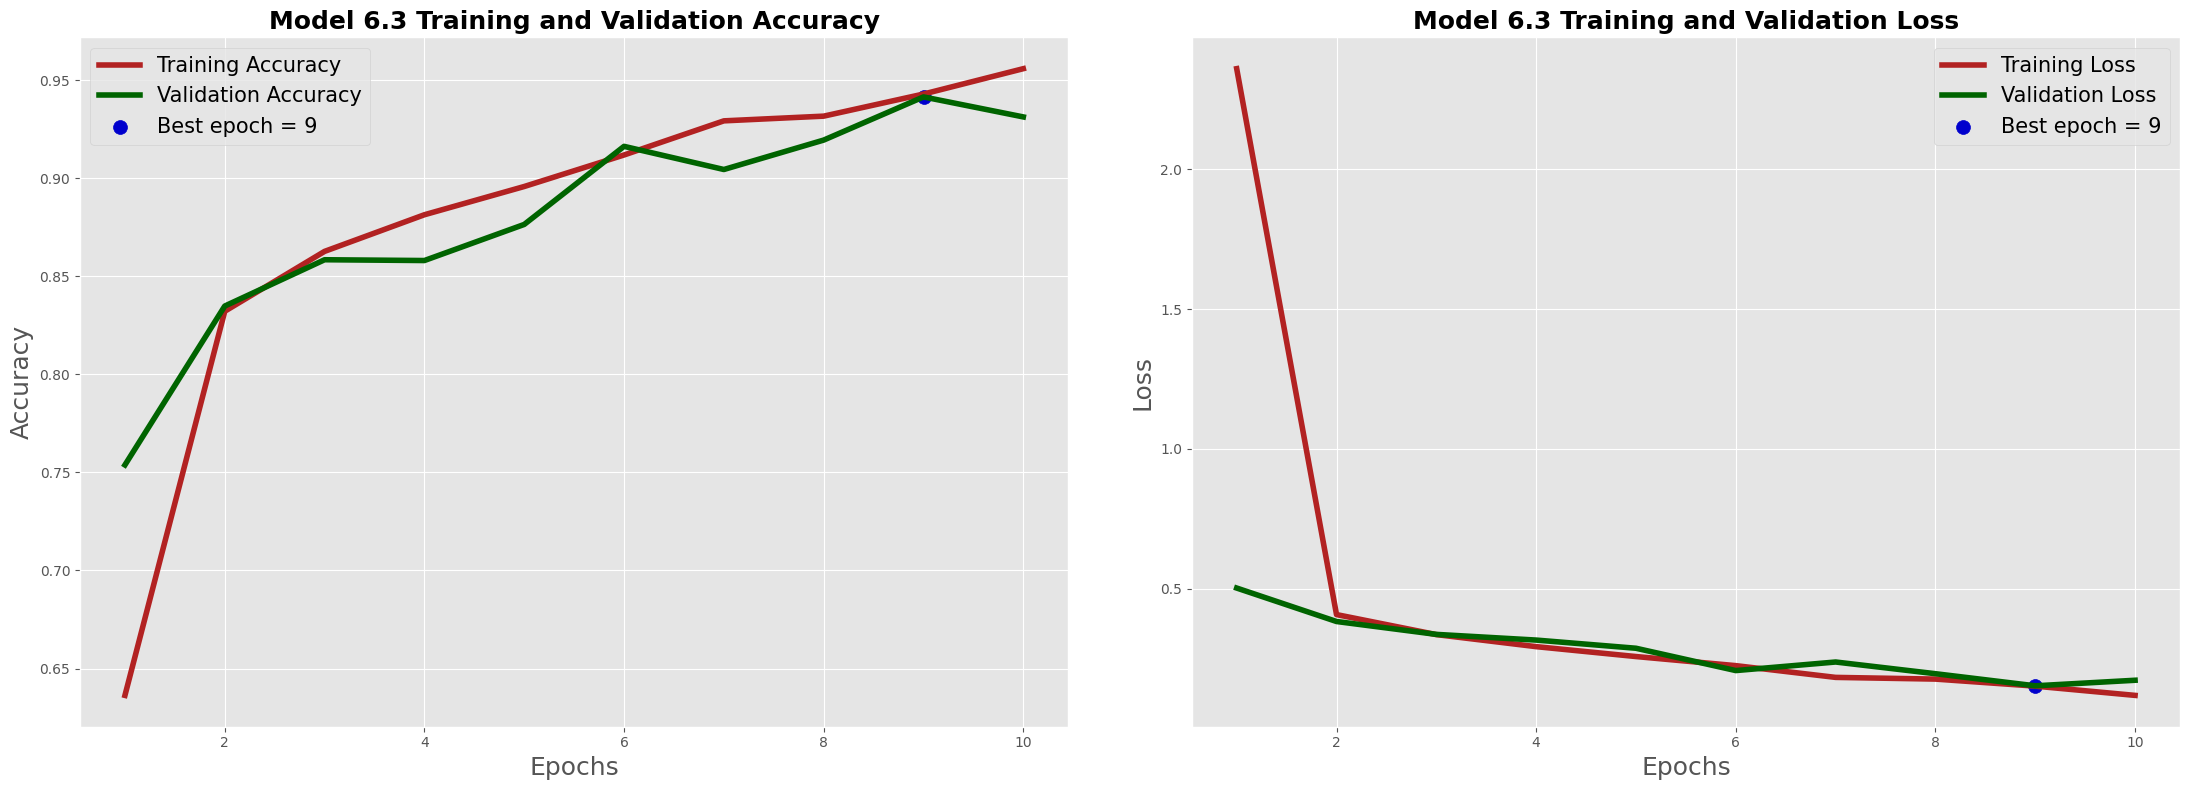

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.86      0.99      0.92      1000
        Colon adenocarcinoma       0.98      0.84      0.90      1000
          Lung Benign Tissue       1.00      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.90      0.95      0.93      1000
         Lung adenocarcinoma       0.94      0.88      0.91      1000

                    accuracy                           0.93      5000
                   macro avg       0.94      0.93      0.93      5000
                weighted avg       0.94      0.93      0.93      5000



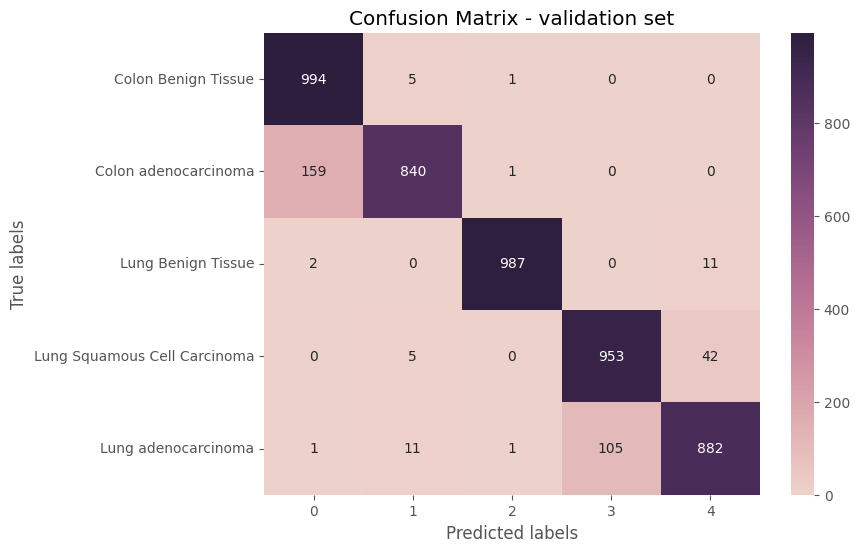

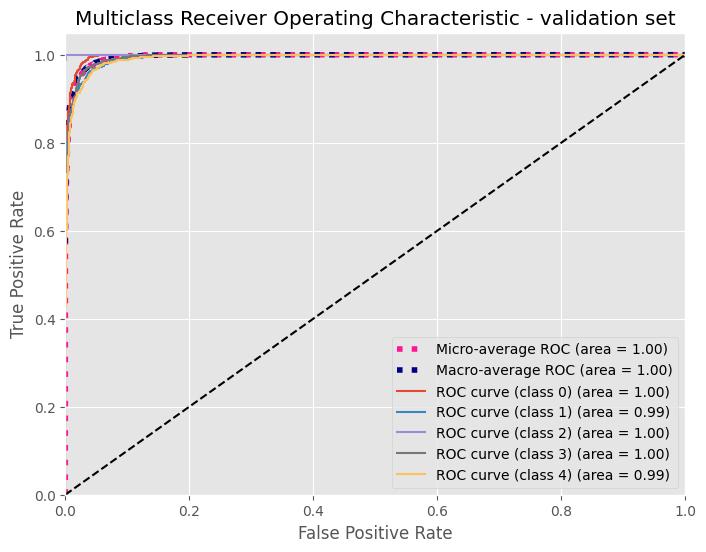

In [ ]:
plot_history(history, 'Model 6.3')
plot_cm(model6, X_val, y_val, 'validation')
plot_roc(model6, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model6_3.pkl', 'wb') as file:
  pickle.dump(results, file)

## Models 7 and 8 - regularization

In [ ]:
from tensorflow.keras.layers import Dropout

def dropout_model(do_rate=0.2, n_classes=n_classes, input_shape=X_train.shape[1:]):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                            input_shape=input_shape, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(do_rate))
    model.add(layers.Dense(32, activation='relu'))
    model.add(Dropout(do_rate))
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model


### Model 7_1: dropout 0.4

In [ ]:
# Instantiate the model
model7 = dropout_model(0.4)

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 128)        

In [ ]:
# Compile the model
model7.compile(optimizer='adam', metrics=['accuracy'],
                  loss='categorical_crossentropy')

# Train the model
history = model7.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model7.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 14s 51ms/step - loss: 2.0418 - accuracy: 0.3803 - val_loss: 0.8981 - val_accuracy: 0.6010
Epoch 2/10
118/118 [==============================] - 3s 29ms/step - loss: 0.9423 - accuracy: 0.5554 - val_loss: 0.7432 - val_accuracy: 0.6844
Epoch 3/10
118/118 [==============================] - 3s 23ms/step - loss: 0.7731 - accuracy: 0.6609 - val_loss: 0.5151 - val_accuracy: 0.8124
Epoch 4/10
118/118 [==============================] - 3s 23ms/step - loss: 0.6529 - accuracy: 0.7195 - val_loss: 0.5072 - val_accuracy: 0.7202
Epoch 5/10
118/118 [==============================] - 3s 23ms/step - loss: 0.6131 - accuracy: 0.7481 - val_loss: 0.3999 - val_accuracy: 0.7626
Epoch 6/10
118/118 [==============================] - 3s 25ms/step - loss: 0.5233 - accuracy: 0.7932 - val_loss: 0.3375 - val_accuracy: 0.9030
Epoch 7/10
118/118 [==============================] - 3s 23ms/step - loss: 0.4737 - accuracy: 0.8227 - val_loss: 0.3533 - val_accuracy: 0.879

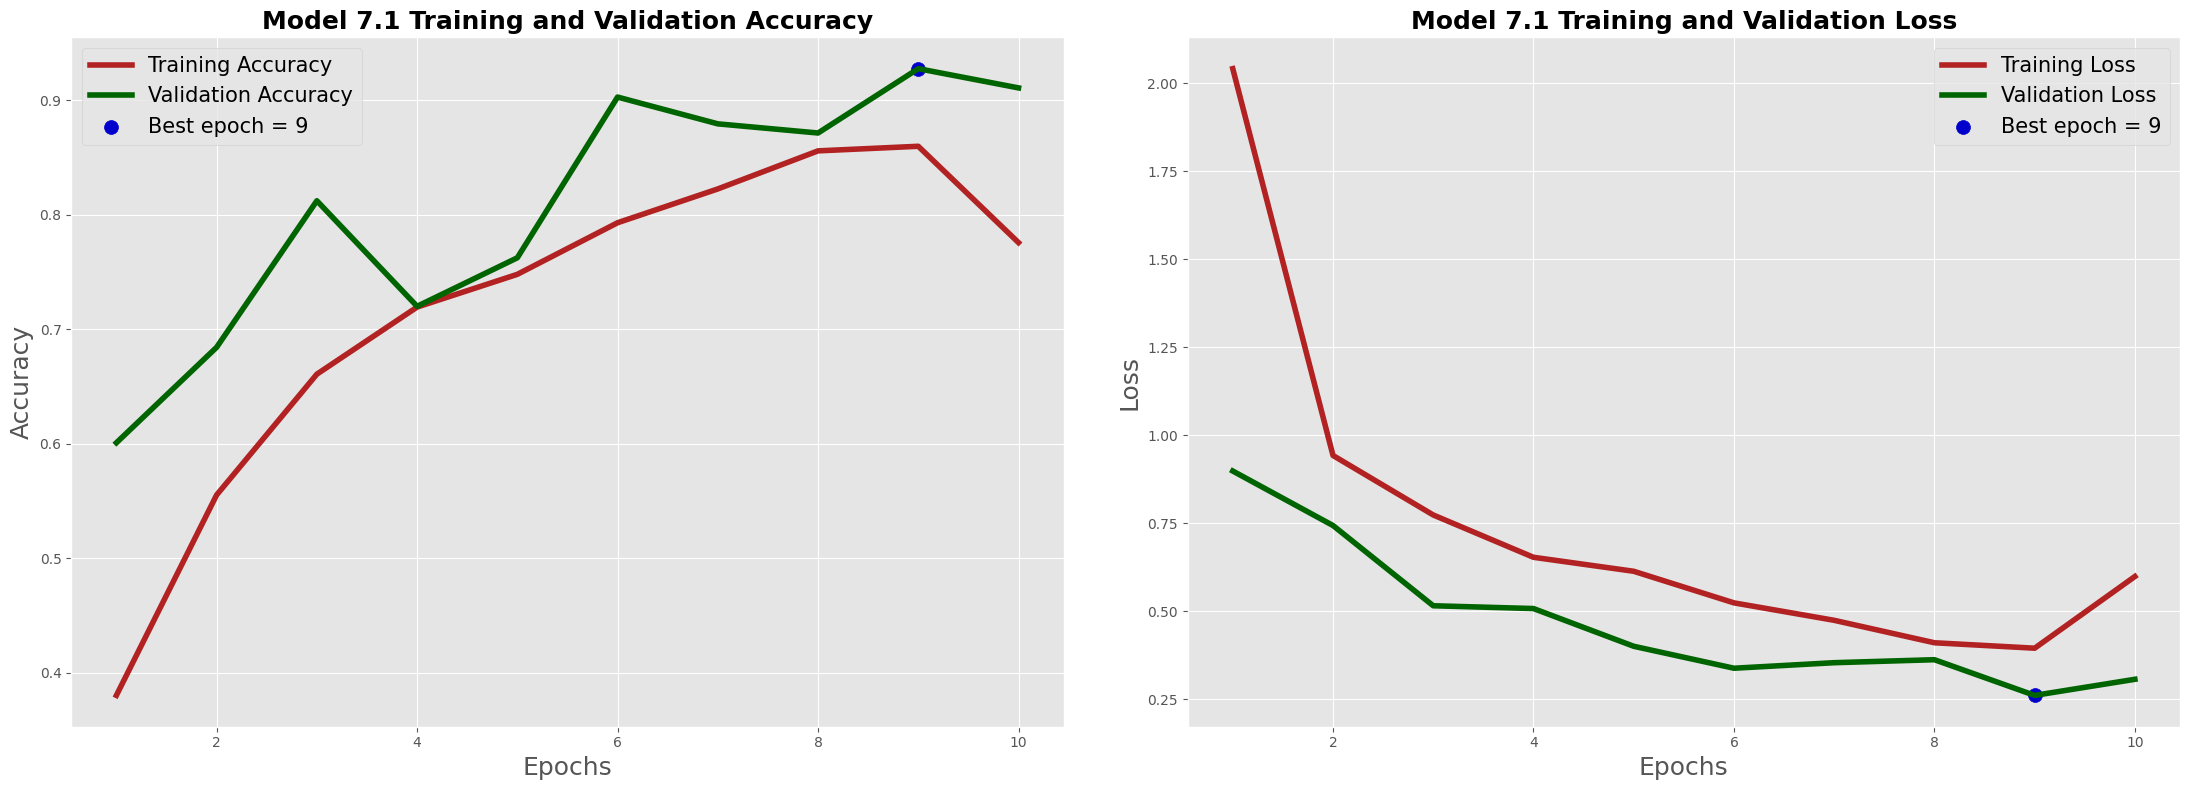

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.97      0.77      0.86      1000
        Colon adenocarcinoma       0.80      0.97      0.88      1000
          Lung Benign Tissue       1.00      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.93      0.91      0.92      1000
         Lung adenocarcinoma       0.90      0.92      0.91      1000

                    accuracy                           0.91      5000
                   macro avg       0.92      0.91      0.91      5000
                weighted avg       0.92      0.91      0.91      5000



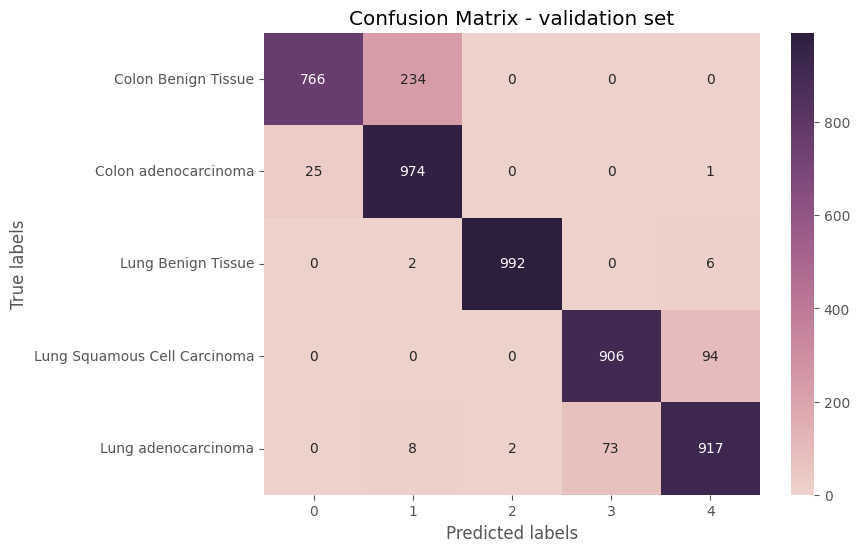

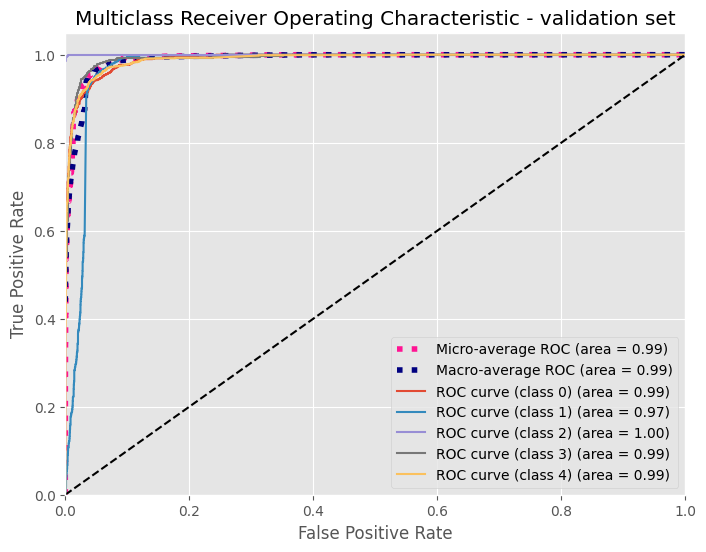

In [ ]:
plot_history(history, 'Model 7.1')
plot_cm(model7, X_val, y_val, 'validation')
plot_roc(model7, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model7_1.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 7_2: dropout 0.2

In [ ]:
# Instantiate the model
model7 = dropout_model(0.2)

# Compile the model
model7.compile(optimizer='adam', metrics=['accuracy'],
                  loss='categorical_crossentropy')

# Train the model
history = model7.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model7.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/10
118/118 [==============================] - 7s 30ms/step - loss: 2.1213 - accuracy: 0.5005 - val_loss: 0.5149 - val_accuracy: 0.8066
Epoch 2/10
118/118 [==============================] - 3s 27ms/step - loss: 0.9287 - accuracy: 0.5769 - val_loss: 0.7977 - val_accuracy: 0.6364
Epoch 3/10
118/118 [==============================] - 3s 23ms/step - loss: 0.8125 - accuracy: 0.6376 - val_loss: 0.5682 - val_accuracy: 0.7596
Epoch 4/10
118/118 [==============================] - 3s 23ms/step - loss: 0.7004 - accuracy: 0.6986 - val_loss: 0.5918 - val_accuracy: 0.7228
Epoch 5/10
118/118 [==============================] - 3s 26ms/step - loss: 0.5704 - accuracy: 0.7596 - val_loss: 0.4368 - val_accuracy: 0.8082
Epoch 6/10
118/118 [==============================] - 3s 26ms/step - loss: 0.4840 - accuracy: 0.8029 - val_loss: 0.4032 - val_accuracy: 0.8320
Epoch 7/10
118/118 [==============================] - 3s 24ms/step - loss: 0.3921 - accuracy: 0.8498 - val_loss: 0.2858 - val_accuracy: 0.8942

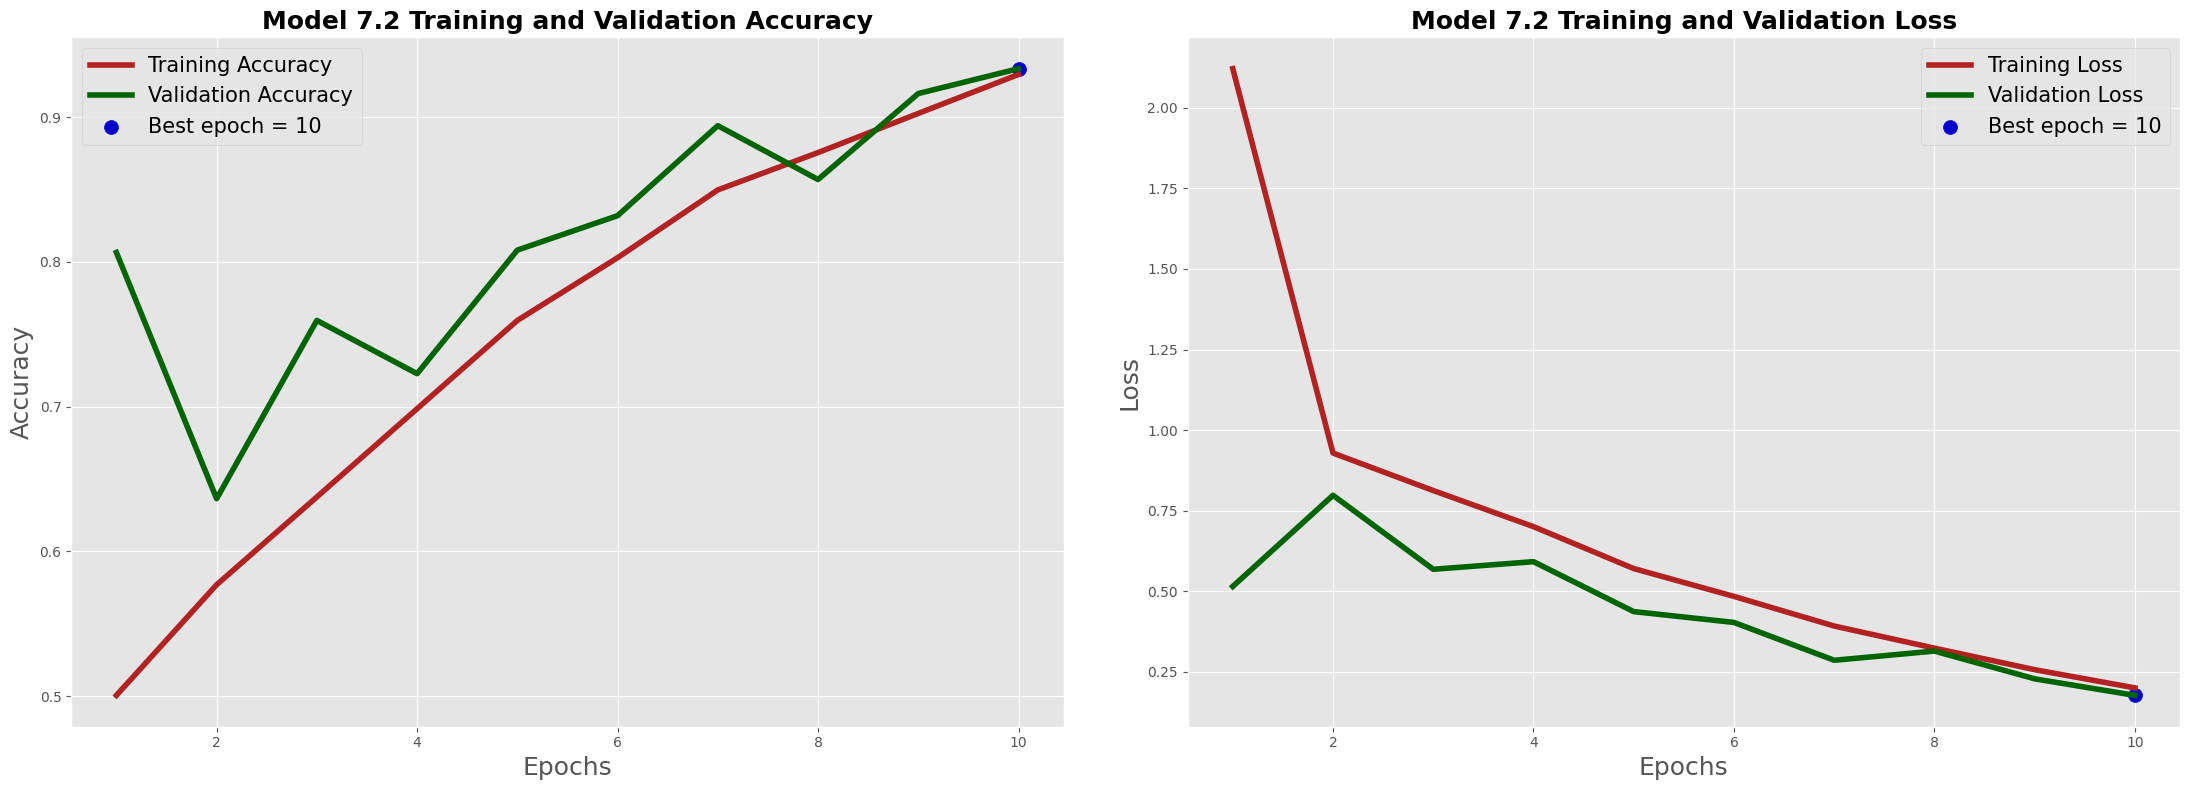

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.89      0.99      0.94      1000
        Colon adenocarcinoma       0.98      0.88      0.93      1000
          Lung Benign Tissue       0.99      1.00      0.99      1000
Lung Squamous Cell Carcinoma       0.92      0.91      0.91      1000
         Lung adenocarcinoma       0.90      0.90      0.90      1000

                    accuracy                           0.93      5000
                   macro avg       0.94      0.93      0.93      5000
                weighted avg       0.94      0.93      0.93      5000



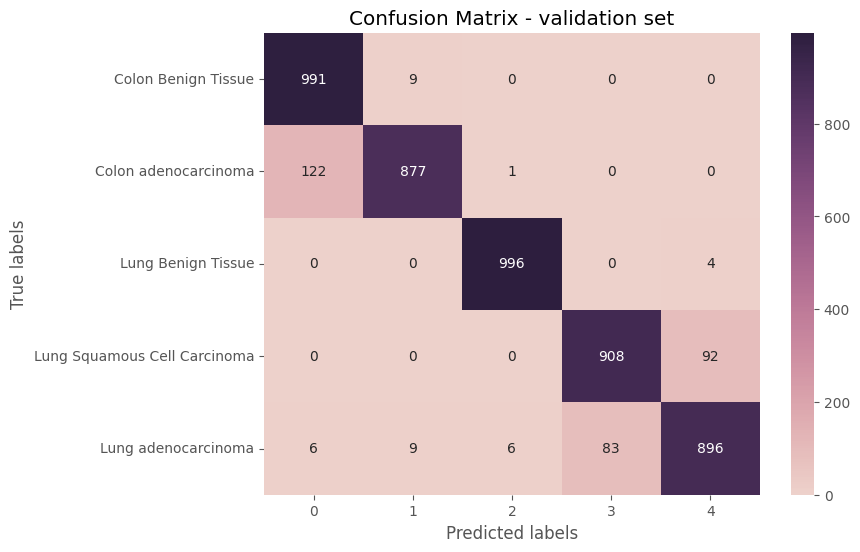

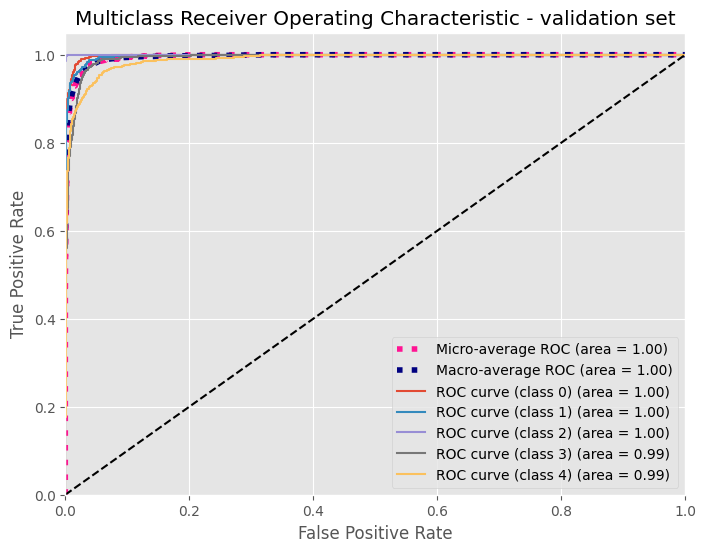

In [ ]:
plot_history(history, 'Model 7.2')
plot_cm(model7, X_val, y_val, 'validation')
plot_roc(model7, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model7_2.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 8.1: L2 regularizer

In [ ]:
K.clear_session()
from tensorflow.keras import regularizers

def regularizer_model(regularizer=regularizers.l2(0.001), n_classes=n_classes, input_shape=X_train.shape[1:]):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                            input_shape=input_shape, activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer=regularizer))
    model.add(layers.Dense(32, activation='relu',
                           kernel_regularizer=regularizer))
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

model8 = regularizer_model()

# Compile the model
model8.compile(optimizer='adam', metrics=['accuracy'],
                  loss='categorical_crossentropy')

# Train the model
history = model8.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model8.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


Epoch 1/10
118/118 [==============================] - 9s 37ms/step - loss: 2.4764 - accuracy: 0.6697 - val_loss: 0.9168 - val_accuracy: 0.7726
Epoch 2/10
118/118 [==============================] - 3s 26ms/step - loss: 0.7998 - accuracy: 0.8279 - val_loss: 0.7675 - val_accuracy: 0.8352
Epoch 3/10
118/118 [==============================] - 3s 26ms/step - loss: 0.7224 - accuracy: 0.8578 - val_loss: 0.6482 - val_accuracy: 0.8906
Epoch 4/10
118/118 [==============================] - 3s 28ms/step - loss: 0.6297 - accuracy: 0.8941 - val_loss: 0.5614 - val_accuracy: 0.9116
Epoch 5/10
118/118 [==============================] - 3s 26ms/step - loss: 0.5967 - accuracy: 0.9047 - val_loss: 0.5904 - val_accuracy: 0.8966
Epoch 6/10
118/118 [==============================] - 3s 23ms/step - loss: 0.5075 - accuracy: 0.9344 - val_loss: 0.5931 - val_accuracy: 0.8960
Epoch 7/10
118/118 [==============================] - 3s 23ms/step - loss: 0.4785 - accuracy: 0.9427 - val_loss: 0.4638 - val_accuracy: 0.9444

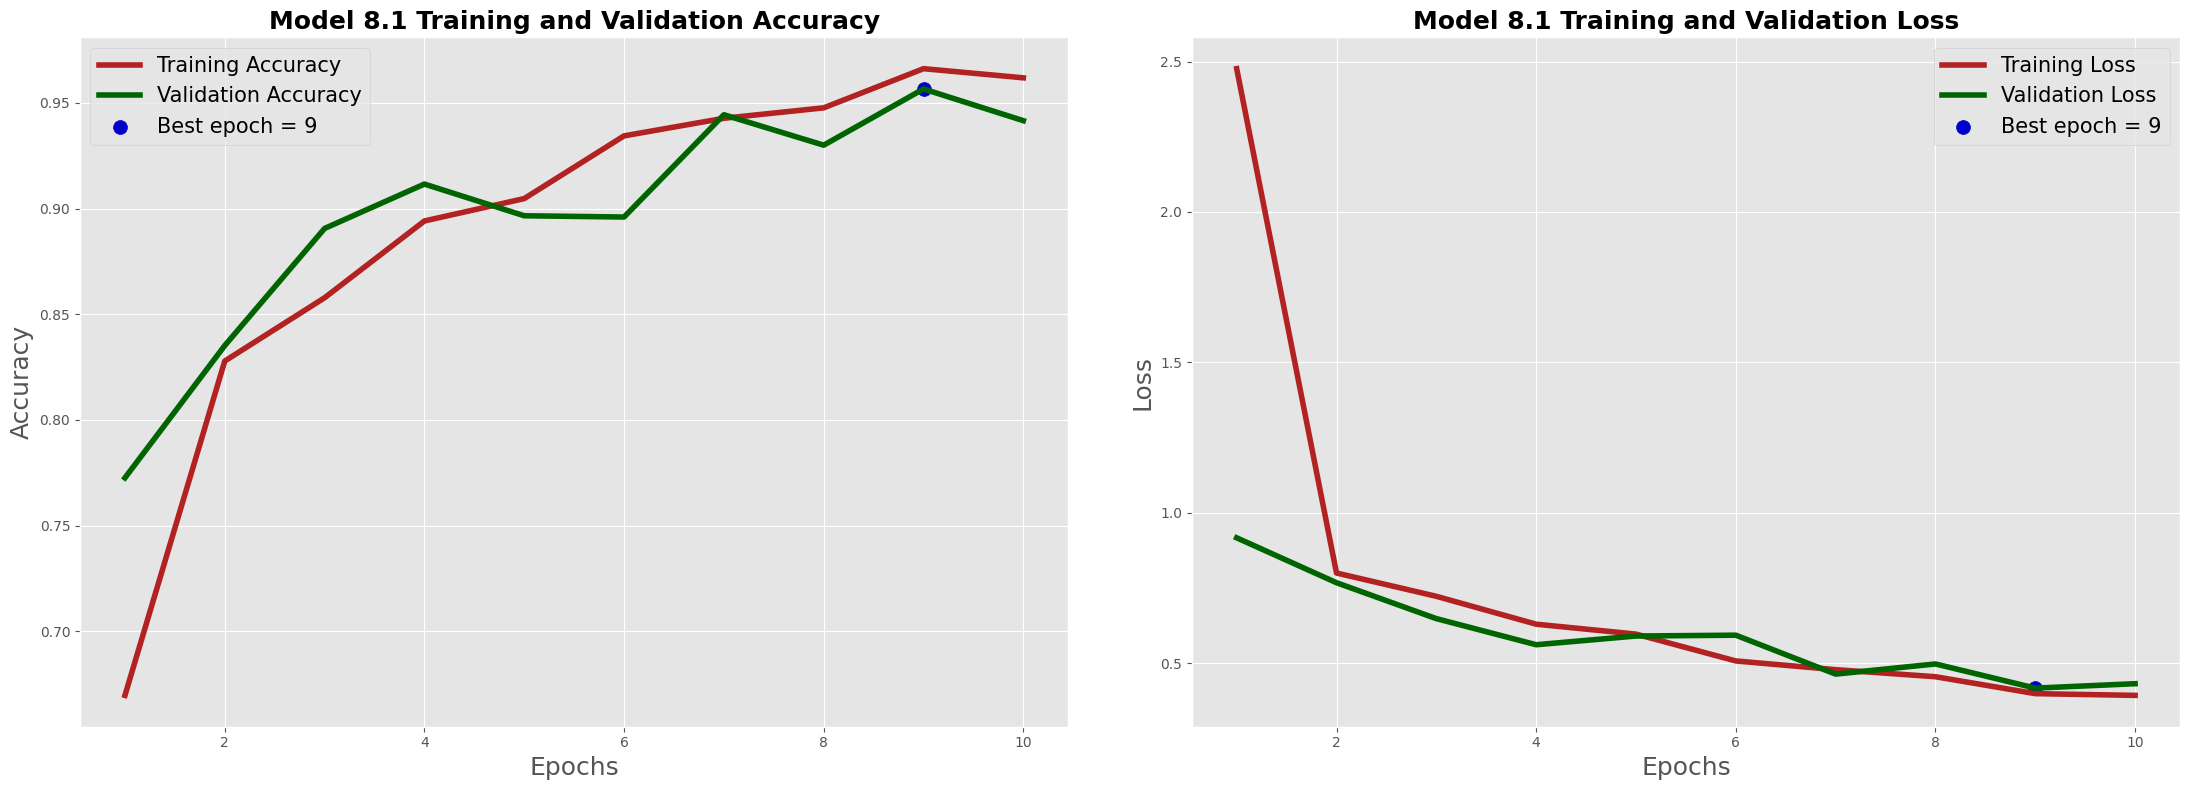

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.95      0.99      0.97      1000
        Colon adenocarcinoma       0.99      0.94      0.96      1000
          Lung Benign Tissue       0.99      1.00      0.99      1000
Lung Squamous Cell Carcinoma       0.83      0.99      0.90      1000
         Lung adenocarcinoma       0.98      0.80      0.88      1000

                    accuracy                           0.94      5000
                   macro avg       0.95      0.94      0.94      5000
                weighted avg       0.95      0.94      0.94      5000



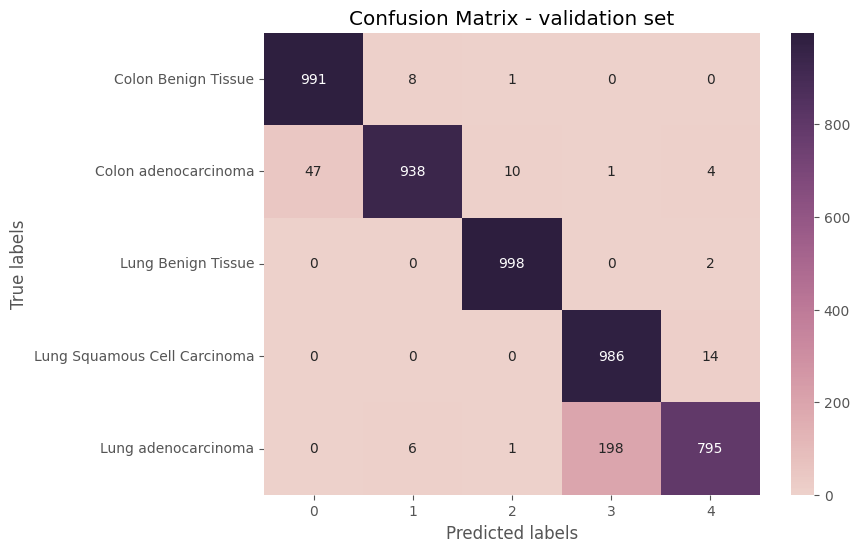

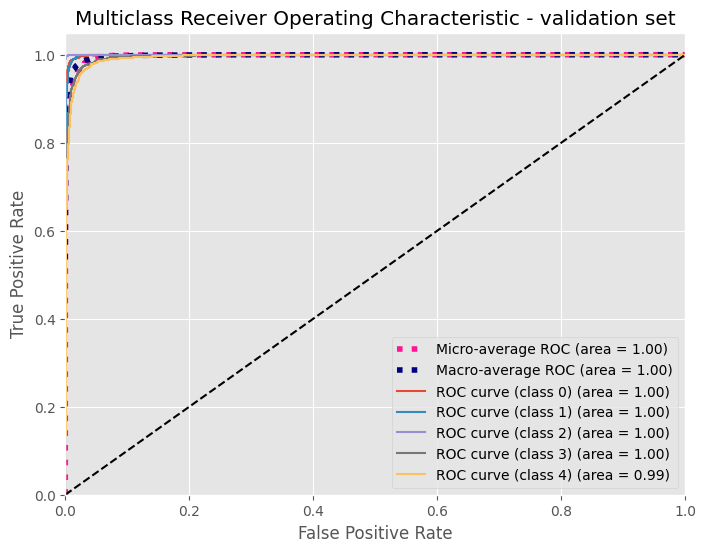

In [ ]:
plot_history(history, 'Model 8.1')
plot_cm(model8, X_val, y_val, 'validation')
plot_roc(model8, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model8.pkl', 'wb') as file:
  pickle.dump(results, file)

### Model 8.2: L2 regularizer with lower learning rate

In [ ]:
model8 = regularizer_model(regularizers.l2(0.00001))

# Compile the model
model8.compile(optimizer='adam', metrics=['accuracy'],
                  loss='categorical_crossentropy')

# Train the model
history = model8.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model8.evaluate(X_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


Epoch 1/10
118/118 [==============================] - 8s 38ms/step - loss: 2.4025 - accuracy: 0.6050 - val_loss: 0.4504 - val_accuracy: 0.8156
Epoch 2/10
118/118 [==============================] - 3s 26ms/step - loss: 0.3767 - accuracy: 0.8494 - val_loss: 0.3633 - val_accuracy: 0.8458
Epoch 3/10
118/118 [==============================] - 3s 23ms/step - loss: 0.2964 - accuracy: 0.8851 - val_loss: 0.2944 - val_accuracy: 0.8756
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.2313 - accuracy: 0.9106 - val_loss: 0.2056 - val_accuracy: 0.9170
Epoch 5/10
118/118 [==============================] - 3s 23ms/step - loss: 0.1773 - accuracy: 0.9344 - val_loss: 0.2252 - val_accuracy: 0.9180
Epoch 6/10
118/118 [==============================] - 3s 23ms/step - loss: 0.1870 - accuracy: 0.9308 - val_loss: 0.1708 - val_accuracy: 0.9316
Epoch 7/10
118/118 [==============================] - 3s 25ms/step - loss: 0.1183 - accuracy: 0.9571 - val_loss: 0.2058 - val_accuracy: 0.9192

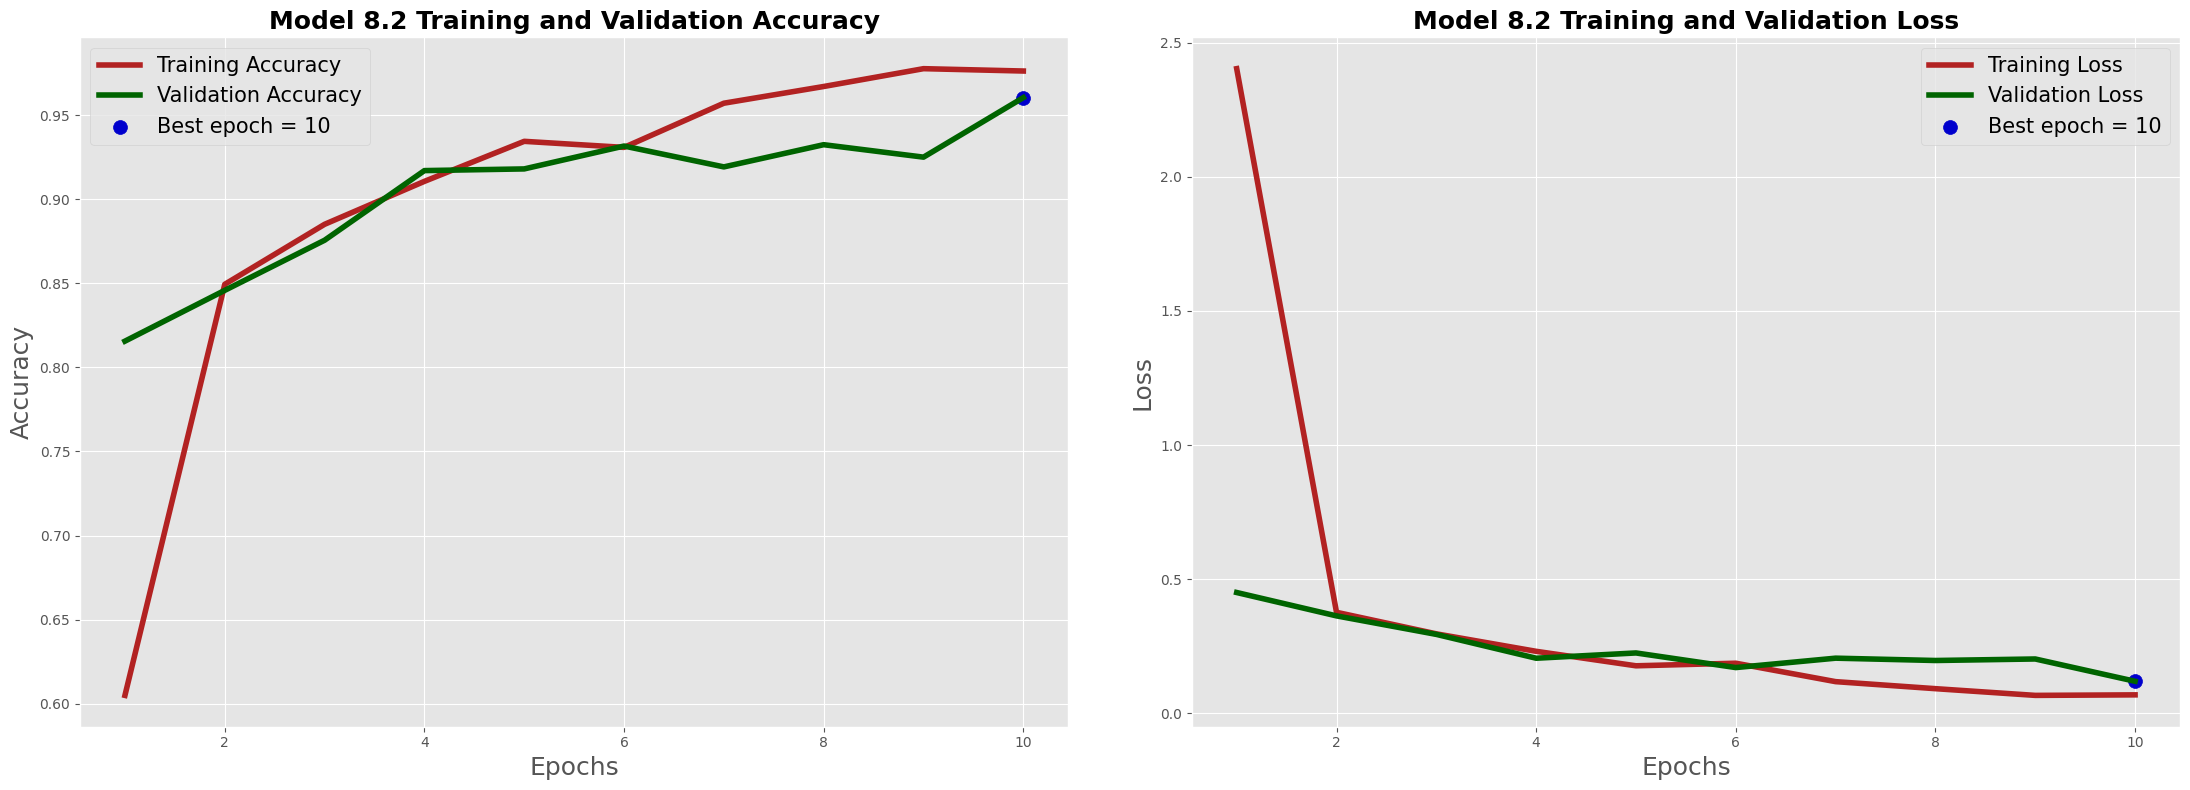

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      0.95      0.98      1000
        Colon adenocarcinoma       0.95      0.99      0.97      1000
          Lung Benign Tissue       1.00      0.99      1.00      1000
Lung Squamous Cell Carcinoma       0.90      0.97      0.94      1000
         Lung adenocarcinoma       0.96      0.89      0.92      1000

                    accuracy                           0.96      5000
                   macro avg       0.96      0.96      0.96      5000
                weighted avg       0.96      0.96      0.96      5000



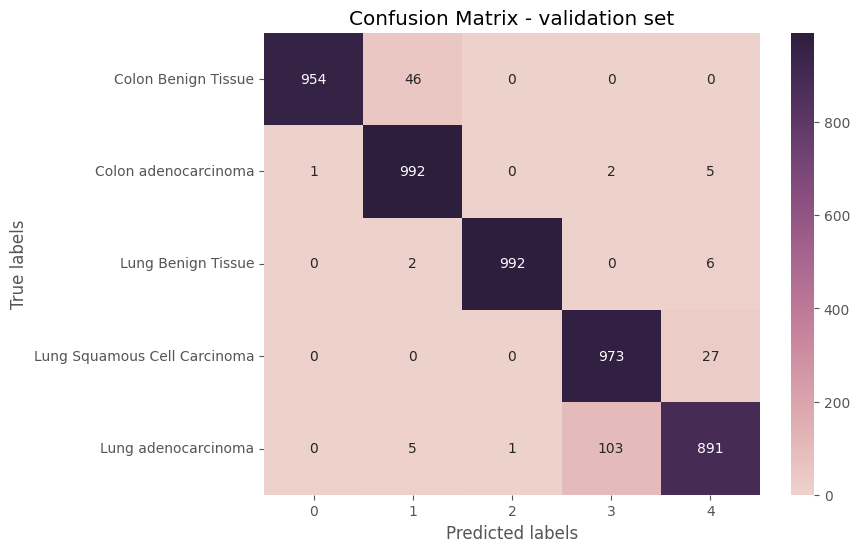

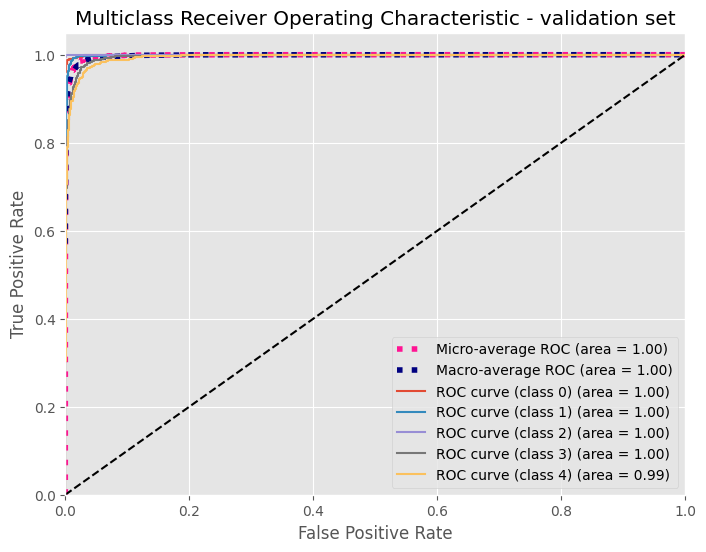

In [ ]:
plot_history(history, 'Model 8.2')
plot_cm(model8, X_val, y_val, 'validation')
plot_roc(model8, X_val, y_val, 'validation')

In [ ]:
# Save the results
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model8.2.pkl', 'wb') as file:
  pickle.dump(results, file)